In [1]:
from helpers import get_sample, folds
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from tabulate import tabulate

models = [
    # Biophysical models
    'gagge',
    'ji',
    'takahashi',
    # Basic ML models
    'ml_ridge_regression',
    'ml_linear_regression',
    # 'ml_neural_network',
    # 'ml_decision_tree',
    # 'ml_lasso_regression',
    # 'ml_bagging_regression',
    # 'ml_random_forest',
    # Sequential ML models
    'ml_rnn',
    'ml_lstm',
    'ml_gru',
    # 'ml_tcn',
    # 'ml_seq2seq'
]

studies = [
    'heatwave 1 (prolonged)',
    'heatwave 3 (cooling)',
    'heatwave 2 (indoor)'
]

conditions = [
    'hot',
    'warm',
    'temp',
    'cool'
]

In [2]:
import pandas as pd
import numpy as np

# COMPILE DATASET

# List of samples, each item is a dataframe for that particular experiment
# The dataframe contains the dataset, as well as the predicted values
samples = []

# Flatten folds to make checking quicker
flat_folds = list(np.array(folds).flat)

for study in studies:
    for condition in conditions:
        # Initialize an empty list to store fold_number DataFrames for each model
        fold_number_dfs = []

        sample = get_sample(study, condition)
        # Drop index
        sample = sample.reset_index(drop=True)
        if (sample.shape[0] > 0):
            # Sample exists
            for model in models:
                try:
                    predicted_filepath = './results/{}-{}-{}.csv'.format(model, study, condition)
                    predicted = pd.read_csv(predicted_filepath)

                    # Check if 'fold_number' column exists
                    if 'fold_number' in predicted.columns:
                        # Cast 'fold_number' to integer, handling missing values
                        predicted['fold_number'] = pd.to_numeric(predicted['fold_number'], errors='coerce').astype('Int64')
                        fold_number_dfs.append(predicted[['fold_number']])

                    # Rename default predicted columns if they exist without model suffix
                    if 'tre_predicted' in predicted.columns:
                      predicted.rename(columns={'tre_predicted': f'tre_predicted_{model}'}, inplace=True)

                    if 'mtsk_predicted' in predicted.columns:
                      predicted.rename(columns={'mtsk_predicted': f'mtsk_predicted_{model}'}, inplace=True)

                    # Ensure predicted columns are numeric
                    for col in predicted.columns:
                        if col.startswith('tre_predicted') or col.startswith('mtsk_predicted'):
                            if predicted[col].dtype != 'float64':
                                print(f'{predicted_filepath} {col} needs to be cast to numeric')
                                predicted[col] = pd.to_numeric(predicted[col], errors='coerce')

                    # Remove fold_number column if it exists to avoid duplicate during concat
                    if 'fold_number' in predicted.columns:
                        predicted = predicted.drop('fold_number', axis=1)

                    # Concat prediction to dataframe
                    sample = pd.concat([sample, predicted], axis=1)
                except FileNotFoundError:
                    print("File not found:", './results/{}-{}-{}.csv'.format(model, study, condition))

            # Check if all fold_number columns are identical for the same study and condition
            if len(fold_number_dfs) > 1:
                for i in range(1, len(fold_number_dfs)):
                    if not fold_number_dfs[0].equals(fold_number_dfs[i]):
                        print(f"Warning: 'fold_number' columns are not identical for study '{study}', condition '{condition}' between models.")
                # Merge fold number back into sample
                sample = sample.join(fold_number_dfs[0])
            elif len(fold_number_dfs) == 1:
                # Merge fold number back into sample
                sample = sample.join(fold_number_dfs[0])

            # Remove any IDs that don't appear in folds
            sample = sample[sample['id_all'].isin(flat_folds)]

            print("Number of missing fold_numbers:", sample['fold_number'].isnull().sum())
            # Save sample to compiled results
            sample.to_csv('results_compiled/{}-{}.csv'.format(study, condition))
            samples.append(sample)

Number of missing fold_numbers: 0
Number of missing fold_numbers: 0
Number of missing fold_numbers: 0
Number of missing fold_numbers: 0
Number of missing fold_numbers: 0
Number of missing fold_numbers: 0


In [9]:
# Merge all samples together
merged_samples = pd.concat(samples, ignore_index=True)

# Calculate body temperature using the formula Tb = 0.64Tc * 0.36Tsk
merged_samples['tb'] = 0.64 * merged_samples['tre_int'] + 0.36 * merged_samples['mtsk_int']

# Define an empty list to store results
results = []

# Calculate RMSE for each model
for model in models:
    tre_col = 'tre_predicted_{}'.format(model)
    mtsk_col = 'mtsk_predicted_{}'.format(model)
    if tre_col in merged_samples.columns and mtsk_col in merged_samples.columns:
        # Calculate body temperature using the predicted values
        merged_samples['tb_predicted_{}'.format(model)] = 0.64 * merged_samples[tre_col] + 0.36 * merged_samples[mtsk_col]

        # Calculate and round RMSE for tre
        tre_rmse = round(np.sqrt(mean_squared_error(merged_samples[tre_col], merged_samples['tre_int'])), 2)

        # Calculate and round RMSE for mtsk
        mtsk_rmse = round(np.sqrt(mean_squared_error(merged_samples[mtsk_col], merged_samples['mtsk_int'])), 2)

        # Calculate and round RMSE for tb
        tb_rmse = round(np.sqrt(mean_squared_error(merged_samples['tb_predicted_{}'.format(model)], merged_samples['tb'])), 2)

        # Calculate mean RMSE
        # mean_rmse = round((tre_rmse + mtsk_rmse + tb_rmse) / 3, 2)

        # Append results to list
        results.append([model, tre_rmse, mtsk_rmse, tb_rmse])
    else:
        print(f"Columns for model {model} not found in the merged data.")

# Convert the results list to DataFrame for better visualization and compatibility with tabulate
results_df = pd.DataFrame(results, columns=['Model', 'tre_RMSE', 'mtsk_RMSE', 'tb_RMSE'])

# Sort by RMSE
results_df = results_df.sort_values(by='tre_RMSE')

# Convert the DataFrame to LaTeX table
latex_table = tabulate(results_df, tablefmt="latex", headers="keys", showindex=False)

print(latex_table)

\begin{tabular}{lrrr}
\hline
 Model                &   tre\_RMSE &   mtsk\_RMSE &   tb\_RMSE \\
\hline
 ml\_ridge\_regression  &       0.27 &        0.73 &      0.34 \\
 ml\_linear\_regression &       0.28 &        0.75 &      0.35 \\
 ml\_gru               &       0.35 &        0.99 &      0.51 \\
 ji                   &       0.4  &        1.85 &      0.62 \\
 ml\_lstm              &       0.42 &        1.12 &      0.57 \\
 ml\_rnn               &       0.43 &        1.16 &      0.6  \\
 takahashi            &       0.44 &        0.74 &      0.39 \\
 gagge                &       0.59 &        0.87 &      0.58 \\
\hline
\end{tabular}


In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

# Merge all samples together
merged_samples = pd.concat(samples, ignore_index=True)

# Calculate body temperature using the formula Tb = 0.64Tc * 0.36Tsk
merged_samples['tb'] = 0.64 * merged_samples['tre_int'] + 0.36 * merged_samples['mtsk_int']

# Define metric columns
metric_cols = ['tre_RMSE', 'mtsk_RMSE', 'tb_RMSE']

# Desired model order
model_order = ['ml_linear_regression', 'ml_ridge_regression', 'ml_gru', 'ml_lstm', 'ml_rnn', 'ji', 'takahashi', 'gagge']

# Model name mapping
model_name_mapping = {
    "ml_linear_regression": "ML Linear Regression",
    "ml_ridge_regression": "ML Ridge Regression",
    "ml_gru": "ML GRU",
    "ml_lstm": "ML LSTM",
    "ml_rnn": "ML RNN",
    "ji": "Ji",
    "takahashi": "Takahashi",
    "gagge": "Gagge"
}

# Initialize an empty dictionary to store LaTeX tables
latex_tables = {}

# Calculate RMSE for each model and each fold
for metric in metric_cols:
    results = []
    for model in models:
        tre_col = 'tre_predicted_{}'.format(model)
        mtsk_col = 'mtsk_predicted_{}'.format(model)

        if tre_col in merged_samples.columns and mtsk_col in merged_samples.columns:
            merged_samples['tb_predicted_{}'.format(model)] = 0.64 * merged_samples[tre_col] + 0.36 * merged_samples[mtsk_col]

            for fold in merged_samples['fold_number'].unique():
                fold_data = merged_samples[merged_samples['fold_number'] == fold]

                if metric == 'tre_RMSE':
                    rmse = round(np.sqrt(mean_squared_error(fold_data[tre_col], fold_data['tre_int'])), 2)
                elif metric == 'mtsk_RMSE':
                    rmse = round(np.sqrt(mean_squared_error(fold_data[mtsk_col], fold_data['mtsk_int'])), 2)
                elif metric == 'tb_RMSE':
                    rmse = round(np.sqrt(mean_squared_error(fold_data['tb_predicted_{}'.format(model)], fold_data['tb'])), 2)

                results.append([model, fold, rmse])
        else:
            print(f"Columns for model {model} not found in the merged data.")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results, columns=['Model', 'Fold', metric])

    # Pivot the DataFrame to have models as columns and folds as rows
    pivoted_results = results_df.pivot(index='Model', columns='Fold', values=metric)

    # Sort by the first fold's performance for consistency
    pivoted_results = pivoted_results.sort_values(by=pivoted_results.columns[0])

    # Calculate mean and standard deviation across folds
    pivoted_results['Mean'] = round(pivoted_results.mean(axis=1),2)
    pivoted_results['SD'] = round(pivoted_results.std(axis=1),2)

    # Format the 'Mean ± SD' column
    pivoted_results['Mean ± SD'] = pivoted_results.apply(lambda row: f"{row['Mean']} ± {row['SD']}", axis=1)

    # Drop the individual 'Mean' and 'SD' columns
    pivoted_results = pivoted_results.drop(columns=['Mean', 'SD'])

    # Reorder columns according to model_order, adding missing models with NaN values
    existing_models = pivoted_results.index.tolist()
    for model in model_order:
        if model not in existing_models:
            pivoted_results.loc[model] = [np.nan] * len(pivoted_results.columns)
    pivoted_results = pivoted_results.loc[model_order]

    # Rename index using the mapping
    pivoted_results = pivoted_results.rename(index=model_name_mapping)

    # Transpose the table
    pivoted_results = pivoted_results.transpose()

    # Convert to LaTeX table
    latex_table = tabulate(pivoted_results, tablefmt="latex", headers="keys", showindex=True, floatfmt=".2f")
    latex_tables[metric] = latex_table

# Print the LaTeX tables
for metric, table in latex_tables.items():
    print(f"\\textbf{{{metric}}}")
    print(table)
    print("\n")

\textbf{tre_RMSE}
\begin{tabular}{lllllllll}
\hline
 Fold      & ML Linear Regression   & ML Ridge Regression   & ML GRU      & ML LSTM     & ML RNN      & Ji         & Takahashi   & Gagge       \\
\hline
 1         & 0.28                   & 0.28                  & 0.35        & 0.43        & 0.43        & 0.35       & 0.41        & 0.63        \\
 2         & 0.26                   & 0.26                  & 0.33        & 0.43        & 0.45        & 0.38       & 0.44        & 0.62        \\
 3         & 0.25                   & 0.24                  & 0.32        & 0.38        & 0.38        & 0.41       & 0.46        & 0.54        \\
 4         & 0.31                   & 0.31                  & 0.42        & 0.42        & 0.43        & 0.47       & 0.46        & 0.58        \\
 Mean ± SD & 0.28 ± 0.02            & 0.27 ± 0.03           & 0.36 ± 0.04 & 0.42 ± 0.02 & 0.42 ± 0.03 & 0.4 ± 0.04 & 0.44 ± 0.02 & 0.59 ± 0.04 \\
\hline
\end{tabular}


\textbf{mtsk_RMSE}
\begin{tabular}{lllllll

In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import re

def replace_heatwave_terms(text):
    """
    Replace specific heatwave-related patterns in text with numbered values.

    Args:
        text (str): Input text containing heatwave patterns

    Returns:
        str: Text with replaced patterns
    """
    replacements = [
        (r'heatwave 1 \(prolonged\)hot', '1'),
        (r'heatwave 3 \(cooling\)hot', '2'),
        (r'heatwave 2 \(indoor\)hot', '3'),
        (r'heatwave 2 \(indoor\)warm', '4'),
        (r'heatwave 2 \(indoor\)temp', '5'),
        (r'heatwave 2 \(indoor\)cool', '6')
    ]

    result = text
    for pattern, replacement in replacements:
        result = re.sub(pattern, replacement, result)

    return result

def calculate_metrics(merged_samples, models):
    """
    Calculate RMSE and MBE metrics for each individual across different studies.

    Parameters:
    merged_samples (pd.DataFrame): DataFrame containing all samples
    models (list): List of model names

    Returns:
    pd.DataFrame: DataFrame with individual RMSE and MBE metrics
    """
    # Create a copy of the input DataFrame to avoid modifying the original
    df = merged_samples.copy()

    # Calculate body temperature for actual values
    df['tb'] = 0.64 * df['tre_int'] + 0.36 * df['mtsk_int']

    # Initialize list to store individual results
    individual_results = []

    # Get unique individual IDs
    unique_ids = df['id_all'].unique()

    for id_num in unique_ids:
        # Create mask for current individual
        mask = df['id_all'] == id_num

        # Get unique studies for this individual
        df['study_condition'] = df['study'] + df['condition']
        studies = sorted(df.loc[mask, 'study_condition'].unique())
        studies = [replace_heatwave_terms(study) for study in studies]
        studies = sorted(studies)
        studies_str = ', '.join(studies)
         # Fold number
        fold_number = df.loc[mask, 'fold_number'].unique()[0]

        for model in models:
            tre_col = f'tre_predicted_{model}'
            mtsk_col = f'mtsk_predicted_{model}'

            if tre_col in df.columns and mtsk_col in df.columns:
                # Find sex
                sex_str = 'Male' if df.loc[mask, 'female'].reset_index(drop=True)[0] == 0 else 'Female'
                # Calculate predicted body temperature for all rows at once
                tb_predicted = 0.64 * df.loc[mask, tre_col] + 0.36 * df.loc[mask, mtsk_col]

                # Calculate RMSE for each metric
                tre_rmse = round(np.sqrt(mean_squared_error(
                    df.loc[mask, tre_col],
                    df.loc[mask, 'tre_int']
                )), 2)

                mtsk_rmse = round(np.sqrt(mean_squared_error(
                    df.loc[mask, mtsk_col],
                    df.loc[mask, 'mtsk_int']
                )), 2)

                tb_rmse = round(np.sqrt(mean_squared_error(
                    tb_predicted,
                    df.loc[mask, 'tb']
                )), 2)

                # Calculate MBE for each metric
                tre_mbe = round(np.mean(
                    df.loc[mask, tre_col] - df.loc[mask, 'tre_int']
                ), 2)

                mtsk_mbe = round(np.mean(
                    df.loc[mask, mtsk_col] - df.loc[mask, 'mtsk_int']
                ), 2)

                tb_mbe = round(np.mean(
                    tb_predicted - df.loc[mask, 'tb']
                ), 2)

                # Append results
                individual_results.append({
                    'id_all': id_num,
                    'sex': sex_str,
                    'tested under conditions': studies_str,
                    'fold number': fold_number,
                    'model': model,
                    'tre_RMSE': tre_rmse,
                    'tre_MBE': tre_mbe,
                    'mtsk_RMSE': mtsk_rmse,
                    'mtsk_MBE': mtsk_mbe,
                    'tb_RMSE': tb_rmse,
                    'tb_MBE': tb_mbe
                })
            else:
                print(f"Columns for model {model} not found in the merged data.")

    # Convert results to DataFrame
    results_df = pd.DataFrame(individual_results)

    # Sort by ID and model
    results_df = results_df.sort_values(['id_all', 'model'])

    return results_df

merged_samples = pd.concat(samples, ignore_index=True)
individual_metrics = calculate_metrics(merged_samples, models)
individual_metrics

,id_all,sex,tested under conditions,fold number,model,tre_RMSE,tre_MBE,mtsk_RMSE,mtsk_MBE,tb_RMSE,tb_MBE
4,21,Male,1,3,gagge,0.65,-0.56,0.56,-0.42,0.56,-0.51
0,21,Male,1,3,ji,0.31,-0.03,1.56,-1.45,0.60,-0.54
5,21,Male,1,3,ml_gru,0.19,-0.03,0.31,0.02,0.17,-0.01
3,21,Male,1,3,ml_linear_regression,0.14,-0.11,0.70,0.20,0.23,0.00
1,21,Male,1,3,ml_ridge_regression,0.14,-0.11,0.67,0.22,0.22,0.01
...,...,...,...,...,...,...,...,...,...,...,...
438,98,Female,"3, 4",2,ji,0.19,-0.09,0.94,-0.76,0.40,-0.33
443,98,Female,"3, 4",2,ml_gru,0.21,-0.17,0.76,0.19,0.26,-0.04
441,98,Female,"3, 4",2,ml_linear_regression,0.21,-0.14,0.66,0.34,0.21,0.03
439,98,Female,"3, 4",2,ml_ridge_regression,0.19,-0.12,0.65,0.32,0.21,0.04


In [ ]:
def create_model_tables(individual_rmse):
    """
    Create separate DataFrames for each model and calculate summary statistics.
    Now includes mean and standard deviation as the bottom row with line breaks.

    Parameters:
    individual_rmse (pd.DataFrame): DataFrame containing RMSE and MBE metrics for all models

    Returns:
    dict: Dictionary containing separate DataFrames for each model and their summary statistics
    """
    # Get unique models
    models = individual_rmse['model'].unique()

    # Dictionary to store results
    model_tables = {}

    # Rename columns for better formatting
    column_mapping = {
        'id_all': 'ID',
        'sex': 'Sex',
        'tested under conditions': 'Tested under conditions',
        'fold number': 'Fold number',
        'tre_RMSE': 'Tre RMSE',
        'tre_MBE': 'Tre MBE',
        'mtsk_RMSE': 'mTsk RMSE',
        'mtsk_MBE': 'mTsk MBE',
        'tb_RMSE': 'Tb RMSE',
        'tb_MBE': 'Tb MBE'
    }

    for model in models:
        # Filter data for current model
        model_data = individual_rmse[individual_rmse['model'] == model].copy()

        # Reset index and drop the model column since it's redundant
        model_data = model_data.reset_index(drop=True).drop('model', axis=1)

        # Rename columns
        model_data = model_data.rename(columns=column_mapping)

        # Format numeric columns to always show 2 decimal places
        numeric_columns = [col for col in model_data.columns if 'RMSE' in col or 'MBE' in col]

        # Calculate mean and std before formatting numbers
        means = model_data[numeric_columns].mean()
        stds = model_data[numeric_columns].std()

        # Format numeric data
        for col in numeric_columns:
            model_data[col] = model_data[col].apply(lambda x: f"{x:.2f}")

        # Create mean ± std row with line breaks
        mean_std_row = pd.DataFrame({
            'ID': 'Mean ± SD',
            'Sex': '',
            'Tested under conditions': '',
            'Fold number': ''
        }, index=[0])

        # Add formatted mean ± std for numeric columns with line breaks
        for col in numeric_columns:
            mean_std_row[col] = f"\\makecell{{{means[col]:.2f} \\\\ ± {stds[col]:.2f}}}"

        # Concatenate original data with mean ± std row
        model_data = pd.concat([model_data, mean_std_row], ignore_index=True)

        # Calculate summary statistics
        metrics = ['Tre RMSE', 'Tre MBE', 'mTsk RMSE', 'mTsk MBE', 'Tb RMSE', 'Tb MBE']
        summary_stats = pd.DataFrame({
            'Mean': model_data[metrics].iloc[:-1].astype(float).mean(),  # Exclude the mean row
            'Std': model_data[metrics].iloc[:-1].astype(float).std(),
            'Min': model_data[metrics].iloc[:-1].astype(float).min(),
            'Max': model_data[metrics].iloc[:-1].astype(float).max()
        }).round(2)

        # Store both individual results and summary stats
        model_tables[model] = {
            'individual_results': model_data,
            'summary_stats': summary_stats
        }

    return model_tables

def create_latex_tables(model_tables):
    """
    Create LaTeX formatted tables for each model with placement controls.
    Now includes a bottom row with mean ± standard deviation with line breaks.

    Parameters:
    model_tables (dict): Dictionary containing model-specific DataFrames

    Returns:
    dict: Dictionary containing LaTeX formatted tables for each model
    """
    from tabulate import tabulate

    latex_tables = {}

    caption_template = """
    Performance metrics for the {model} model evaluated independently for each participant (n=76),
    showing Root Mean Square Error (RMSE) and Mean Bias Error (MBE) for core temperature (Tre), mean
    skin temperature (mTsk), and body temperature (Tb) predictions across all experimental conditions. Each
    row represents a single participant's results, demonstrating the model's performance for that individual's
    measured data. All temperatures are in degrees Celsius. Summary statistics (mean ± Standard Deviation)
    across all participants are reported in the bottom row.
    """

    i = 0
    for model, data in model_tables.items():
        i += 1
        # Create caption
        caption = caption_template.format(model=model.replace('_', ' '))

        individual_latex = f"Table S{i}: {caption}\n"

        # Add table with horizontal line before the last row
        table_content = tabulate(
            data['individual_results'],
            headers="keys",
            tablefmt="latex",
            showindex=False,
        )

        # Add horizontal line before the last row
        table_lines = table_content.split('\n')
        insertion_point = -3  # Position to insert the horizontal line
        table_lines.insert(insertion_point, "\\hline")
        table_content = '\n'.join(table_lines)

        individual_latex += table_content

        # Fix escaped backslashes in the makecell command
        individual_latex = individual_latex.replace(
            r'\textbackslash{}makecell\{', r'\makecell{'
        ).replace(
            r'\textbackslash{}\textbackslash{}', r'\\'
        ).replace(
            '\}', '}'
        )

        # Replace tabular with longtable
        individual_latex = individual_latex.replace('begin{tabular}{llllllllll}', 'begin{longtable}{| p{.04\\textwidth} | p{.07\\textwidth} | p{.13\\textwidth} | p{.06\\textwidth} | p{.06\\textwidth} | p{.06\\textwidth} | p{.06\\textwidth} | p{.06\\textwidth} | p{.06\\textwidth} | p{.06\\textwidth} |}')
        individual_latex = individual_latex.replace('end{tabular}', 'end{longtable}')

        # Create LaTeX table for summary statistics
        summary_latex = tabulate(
            data['summary_stats'],
            headers="keys",
            tablefmt="latex",
            showindex=True,
            floatfmt=".2f"
        )

        latex_tables[model] = {
            'individual_results': individual_latex,
            'summary_stats': summary_latex
        }

    return latex_tables

# Print function remains the same
def print_latex_sections(latex_tables):
    print("% Add these to your LaTeX preamble:")
    print("\\usepackage{placeins}")
    print("\\usepackage{float}")
    print("\\usepackage{makecell}")  # Required for \makecell
    print("\n% Adjust float parameters to prioritize placement")
    print("\\renewcommand{\\topfraction}{0.9}")
    print("\\renewcommand{\\bottomfraction}{0.9}")
    print("\\setcounter{topnumber}{2}")
    print("\\setcounter{bottomnumber}{2}")
    print("\n% Document content:")

    for model, data in latex_tables.items():
        print(f"\subsection{{{model.replace('_', ' ').title()}}}\n")
        print(data['individual_results'].replace('\_', ' '))
        print()

# Usage remains the same:
model_tables = create_model_tables(individual_metrics)
latex_tables = create_latex_tables(model_tables)
print_latex_sections(latex_tables)

(76, 10)
(76, 10)
(76, 10)
(76, 10)
(76, 10)
(76, 10)
% Add these to your LaTeX preamble:
\usepackage{placeins}
\usepackage{float}
\usepackage{makecell}

% Adjust float parameters to prioritize placement
\renewcommand{\topfraction}{0.9}
\renewcommand{\bottomfraction}{0.9}
\setcounter{topnumber}{2}
\setcounter{bottomnumber}{2}

% Document content:
\subsection{Gagge}

Table S1: 
    Performance metrics for the gagge model evaluated independently for each participant (n=31),
    showing Root Mean Square Error (RMSE) and Mean Bias Error (MBE) for core temperature (Tre), mean
    skin temperature (mTsk), and body temperature (Tb) predictions across all experimental conditions. Each
    row represents a single participant's results, demonstrating the model's performance for that individual's
    measured data. All temperatures are in degrees Celsius. Summary statistics (mean ± Standard Deviation)
    across all participants are reported in the bottom row.
    
\begin{longtable}{| p{.04\textw

                   model  rmse_type  male_mean  female_mean  difference  \
1                  gagge  mtsk_RMSE      0.758        0.894      -0.136   
4                     ji  mtsk_RMSE      1.788        1.886      -0.099   
7                 ml_gru  mtsk_RMSE      1.506        1.585      -0.079   
10  ml_linear_regression  mtsk_RMSE      0.813        0.821      -0.008   
13               ml_lstm  mtsk_RMSE      1.220        1.206       0.014   
16   ml_ridge_regression  mtsk_RMSE      0.766        0.768      -0.003   
19                ml_rnn  mtsk_RMSE      1.226        1.213       0.013   
22             takahashi  mtsk_RMSE      0.701        0.717      -0.016   
2                  gagge    tb_RMSE      0.526        0.645      -0.119   
5                     ji    tb_RMSE      0.584        0.697      -0.113   
8                 ml_gru    tb_RMSE      0.714        0.747      -0.033   
11  ml_linear_regression    tb_RMSE      0.391        0.355       0.037   
14               ml_lstm 

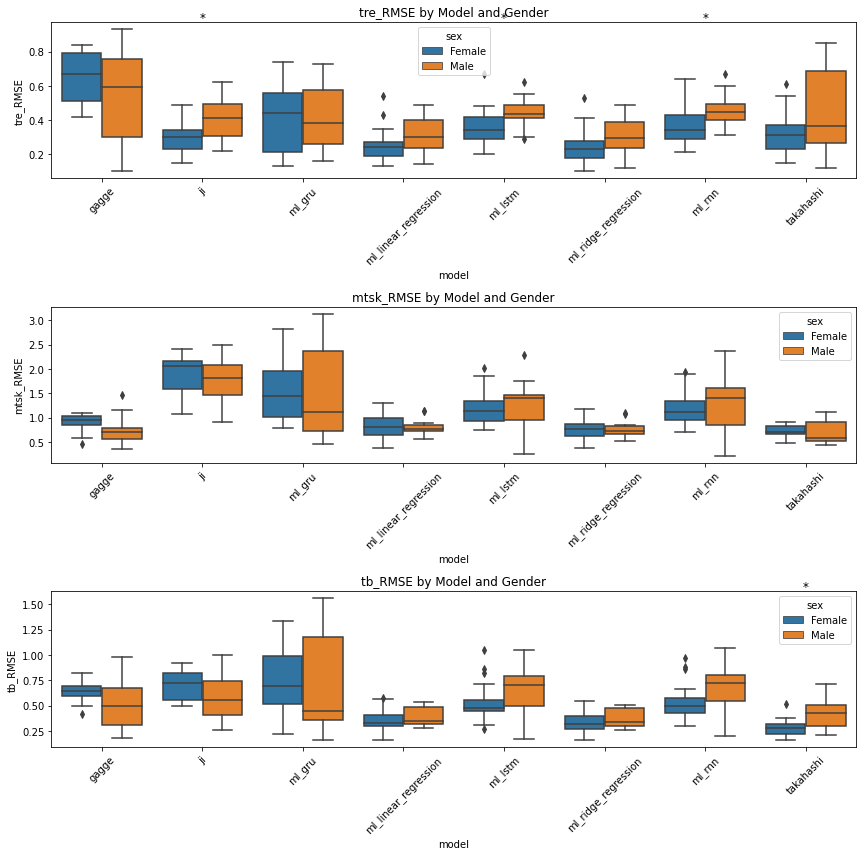

In [6]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_rmse_by_gender(df):
    """
    Analyze RMSE differences between males and females for each model and RMSE type
    using Mann-Whitney U test (non-parametric test suitable for small samples)
    """
    # RMSE columns to analyze
    rmse_cols = ['tre_RMSE', 'mtsk_RMSE', 'tb_RMSE']

    # Store results
    results = []

    # Perform analysis for each model and RMSE type
    for model in df['model'].unique():
        model_data = df[df['model'] == model]

        for rmse_col in rmse_cols:
            # Get male and female data
            male_rmse = model_data[model_data['sex'] == 'Male'][rmse_col]
            female_rmse = model_data[model_data['sex'] == 'Female'][rmse_col]

            # Perform Mann-Whitney U test
            statistic, p_value = stats.mannwhitneyu(
                male_rmse,
                female_rmse,
                alternative='two-sided'
            )

            # Calculate effect size (r = Z / sqrt(N))
            n1, n2 = len(male_rmse), len(female_rmse)
            z_score = stats.norm.ppf(p_value/2)  # Convert p-value to z-score
            effect_size = abs(z_score) / np.sqrt(n1 + n2)

            # Calculate descriptive statistics
            male_mean = male_rmse.mean()
            female_mean = female_rmse.mean()

            results.append({
                'model': model,
                'rmse_type': rmse_col,
                'male_mean': male_mean,
                'female_mean': female_mean,
                'difference': male_mean - female_mean,
                'p_value': p_value,
                'significant': p_value < 0.05,
                'effect_size': effect_size
            })

    return pd.DataFrame(results)

def plot_rmse_comparison(df, results_df):
    """
    Create visualization of RMSE differences between males and females
    """
    rmse_cols = ['tre_RMSE', 'mtsk_RMSE', 'tb_RMSE']
    fig, axes = plt.subplots(len(rmse_cols), 1, figsize=(12, 4*len(rmse_cols)))

    for idx, rmse_col in enumerate(rmse_cols):
        sns.boxplot(
            data=df,
            x='model',
            y=rmse_col,
            hue='sex',
            ax=axes[idx]
        )
        axes[idx].set_title(f'{rmse_col} by Model and Gender')
        axes[idx].tick_params(axis='x', rotation=45)

        # Add significance markers
        sig_results = results_df[
            (results_df['rmse_type'] == rmse_col) &
            (results_df['significant'])
        ]

        y_max = df[rmse_col].max()
        for _, row in sig_results.iterrows():
            model_idx = df['model'].unique().tolist().index(row['model'])
            axes[idx].text(
                model_idx,
                y_max * 1.05,
                '*',
                ha='center',
                fontsize=12
            )

    plt.tight_layout()
    return fig

# Function to run the analysis
def run_rmse_analysis(df):
    """
    Run complete RMSE analysis and return formatted results
    """
    # Perform statistical analysis
    results = analyze_rmse_by_gender(df)

    # Create visualization
    fig = plot_rmse_comparison(df, results)

    # Format results for display
    formatted_results = results.sort_values(['rmse_type', 'model'])
    formatted_results['p_value'] = formatted_results['p_value'].round(4)
    formatted_results['effect_size'] = formatted_results['effect_size'].round(3)
    formatted_results['male_mean'] = formatted_results['male_mean'].round(3)
    formatted_results['female_mean'] = formatted_results['female_mean'].round(3)
    formatted_results['difference'] = formatted_results['difference'].round(3)

    return formatted_results, fig

# Example usage:
results_df, plot = run_rmse_analysis(individual_metrics)
print(results_df)
plt.show()

In [10]:
# Merge all samples together
merged_samples = pd.concat(samples, ignore_index=True)

# Calculate body temperature using the formula Tb = 0.64Tc * 0.36Tsk
merged_samples['tb'] = 0.64 * merged_samples['tre_int'] + 0.36 * merged_samples['mtsk_int']

# Define an empty list to store results
results = []

# Calculate RMSE for each model
for model in models:
    tre_col = 'tre_predicted_{}'.format(model)
    mtsk_col = 'mtsk_predicted_{}'.format(model)
    if tre_col in merged_samples.columns and mtsk_col in merged_samples.columns:
        # Calculate body temperature using the predicted values
        merged_samples['tb_predicted_{}'.format(model)] = 0.64 * merged_samples[tre_col] + 0.36 * merged_samples[mtsk_col]

        # Calculate RMSE for males
        male_data = merged_samples[merged_samples['female'] == 0]
        tre_rmse_male = round(np.sqrt(mean_squared_error(male_data[tre_col], male_data['tre_int'])), 2)
        mtsk_rmse_male = round(np.sqrt(mean_squared_error(male_data[mtsk_col], male_data['mtsk_int'])), 2)
        tb_rmse_male = round(np.sqrt(mean_squared_error(male_data['tb_predicted_{}'.format(model)], male_data['tb'])), 2)

        # Calculate RMSE for females
        female_data = merged_samples[merged_samples['female'] == 1]
        tre_rmse_female = round(np.sqrt(mean_squared_error(female_data[tre_col], female_data['tre_int'])), 2)
        mtsk_rmse_female = round(np.sqrt(mean_squared_error(female_data[mtsk_col], female_data['mtsk_int'])), 2)
        tb_rmse_female = round(np.sqrt(mean_squared_error(female_data['tb_predicted_{}'.format(model)], female_data['tb'])), 2)

        # Append results to list
        results.append([
            model,
            tre_rmse_male, tre_rmse_female,
            mtsk_rmse_male, mtsk_rmse_female,
            tb_rmse_male, tb_rmse_female
        ])
    else:
        print(f"Columns for model {model} not found in the merged data.")

# Convert the results list to DataFrame with separate columns for male and female
results_df = pd.DataFrame(results, columns=[
    'Model',
    'tre_RMSE_male', 'tre_RMSE_female',
    'mtsk_RMSE_male', 'mtsk_RMSE_female',
    'tb_RMSE_male', 'tb_RMSE_female'
])

# Sort by male tre_RMSE
results_df = results_df.sort_values(by='tre_RMSE_male')

# Convert the DataFrame to LaTeX table
latex_table = tabulate(results_df, tablefmt="latex", headers="keys", showindex=False)

print(latex_table)

\begin{tabular}{lrrrrrr}
\hline
 Model                &   tre\_RMSE\_male &   tre\_RMSE\_female &   mtsk\_RMSE\_male &   mtsk\_RMSE\_female &   tb\_RMSE\_male &   tb\_RMSE\_female \\
\hline
 ml\_ridge\_regression  &            0.29 &              0.25 &             0.71 &               0.75 &           0.35 &             0.33 \\
 ml\_linear\_regression &            0.29 &              0.25 &             0.74 &               0.77 &           0.36 &             0.34 \\
 ml\_gru               &            0.36 &              0.35 &             0.99 &               1    &           0.51 &             0.5  \\
 ml\_lstm              &            0.42 &              0.41 &             1.09 &               1.15 &           0.58 &             0.55 \\
 ji                   &            0.44 &              0.33 &             1.77 &               1.97 &           0.56 &             0.7  \\
 ml\_rnn               &            0.44 &              0.41 &             1.15 &               1.19 &       

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
from scipy import stats

# Merge all samples together
merged_samples = pd.concat(samples, ignore_index=True)

# Calculate body temperature using the formula Tb = 0.64Tc * 0.36Tsk
merged_samples['tb'] = 0.64 * merged_samples['tre_int'] + 0.36 * merged_samples['mtsk_int']

# Lists to store all RMSEs for distribution analysis
all_male_rmses = []
all_female_rmses = []

# First pass: Calculate individual RMSEs for all models to analyze distribution
for model in models:
    tre_col = 'tre_predicted_{}'.format(model)
    mtsk_col = 'mtsk_predicted_{}'.format(model)

    if tre_col in merged_samples.columns and mtsk_col in merged_samples.columns:
        merged_samples['tb_predicted_{}'.format(model)] = 0.64 * merged_samples[tre_col] + 0.36 * merged_samples[mtsk_col]

        # Calculate RMSE for each individual
        for id_num in merged_samples['id_all'].unique():
            ind_data = merged_samples[merged_samples['id_all'] == id_num]

            # Calculate RMSEs
            tre_rmse = np.sqrt(mean_squared_error(ind_data['tre_int'], ind_data[tre_col]))
            mtsk_rmse = np.sqrt(mean_squared_error(ind_data['mtsk_int'], ind_data[mtsk_col]))
            tb_rmse = np.sqrt(mean_squared_error(ind_data['tb'], ind_data['tb_predicted_{}'.format(model)]))

            # Store based on sex
            if ind_data['female'].iloc[0] == 0:
                all_male_rmses.extend([tre_rmse, mtsk_rmse, tb_rmse])
            else:
                all_female_rmses.extend([tre_rmse, mtsk_rmse, tb_rmse])

# Test overall distributions for normality
_, male_norm_p = stats.shapiro(all_male_rmses)
_, female_norm_p = stats.shapiro(all_female_rmses)
normal_dist = (male_norm_p > 0.05) and (female_norm_p > 0.05)

# Test for overall equal variances
_, levene_p = stats.levene(all_male_rmses, all_female_rmses)
equal_var = levene_p > 0.05

# Select appropriate statistical test based on overall distribution characteristics
if normal_dist:
    if equal_var:
        print("Using Student's t-test (normal distribution, equal variances)")
        def statistical_test(a, b):
            stat, p = stats.ttest_ind(a, b)
            return "t-test", p
    else:
        print("Using Welch's t-test (normal distribution, unequal variances)")
        def statistical_test(a, b):
            stat, p = stats.ttest_ind(a, b, equal_var=False)
            return "Welch's t-test", p
else:
    print("Using Mann-Whitney U test (non-normal distribution)")
    def statistical_test(a, b):
        stat, p = stats.mannwhitneyu(a, b, alternative='two-sided')
        return "Mann-Whitney U", p

# Print distribution characteristics
print(f"\nDistribution Analysis:")
print(f"Male normality p-value: {male_norm_p:.3f}")
print(f"Female normality p-value: {female_norm_p:.3f}")
print(f"Levene's test p-value: {levene_p:.3f}")

# Define empty lists to store results
results = []
statistical_results = []

# Second pass: Calculate statistics using the chosen test
for model in models:
    tre_col = 'tre_predicted_{}'.format(model)
    mtsk_col = 'mtsk_predicted_{}'.format(model)

    if tre_col in merged_samples.columns and mtsk_col in merged_samples.columns:
        # Calculate individual RMSEs
        individual_rmse = []

        for id_num in merged_samples['id_all'].unique():
            ind_data = merged_samples[merged_samples['id_all'] == id_num]

            tre_rmse = np.sqrt(mean_squared_error(ind_data['tre_int'], ind_data[tre_col]))
            mtsk_rmse = np.sqrt(mean_squared_error(ind_data['mtsk_int'], ind_data[mtsk_col]))
            tb_rmse = np.sqrt(mean_squared_error(ind_data['tb'], ind_data['tb_predicted_{}'.format(model)]))

            individual_rmse.append({
                'id': id_num,
                'female': ind_data['female'].iloc[0],
                'tre_rmse': tre_rmse,
                'mtsk_rmse': mtsk_rmse,
                'tb_rmse': tb_rmse
            })

        # Convert to DataFrame
        ind_df = pd.DataFrame(individual_rmse)

        # Calculate group statistics
        male_stats = ind_df[ind_df['female'] == 0]
        female_stats = ind_df[ind_df['female'] == 1]

        # Calculate mean RMSE for each group
        tre_rmse_male = round(male_stats['tre_rmse'].mean(), 2)
        tre_rmse_female = round(female_stats['tre_rmse'].mean(), 2)
        mtsk_rmse_male = round(male_stats['mtsk_rmse'].mean(), 2)
        mtsk_rmse_female = round(female_stats['mtsk_rmse'].mean(), 2)
        tb_rmse_male = round(male_stats['tb_rmse'].mean(), 2)
        tb_rmse_female = round(female_stats['tb_rmse'].mean(), 2)

        # Run the selected statistical test for each metric
        test_name, tre_p = statistical_test(
            male_stats['tre_rmse'],
            female_stats['tre_rmse']
        )
        _, mtsk_p = statistical_test(
            male_stats['mtsk_rmse'],
            female_stats['mtsk_rmse']
        )
        _, tb_p = statistical_test(
            male_stats['tb_rmse'],
            female_stats['tb_rmse']
        )

        # Store results
        results.append([
            model,
            tre_rmse_male, tre_rmse_female,
            mtsk_rmse_male, mtsk_rmse_female,
            tb_rmse_male, tb_rmse_female
        ])

        n_male = len(male_stats)
        n_female = len(female_stats)

        statistical_results.append([
            model,
            f"p={tre_p:.3f}",
            f"p={mtsk_p:.3f}",
            f"p={tb_p:.3f}"
        ])

# Create results DataFrames
results_df = pd.DataFrame(results, columns=[
    'Model',
    'tre_RMSE_male', 'tre_RMSE_female',
    'mtsk_RMSE_male', 'mtsk_RMSE_female',
    'tb_RMSE_male', 'tb_RMSE_female'
])

statistical_df = pd.DataFrame(statistical_results, columns=[
    'Model',
    'tre_p_value',
    'mtsk_p_value',
    'tb_p_value'
])

# Sort both DataFrames by model name for consistency
results_df = results_df.sort_values(by='Model')
statistical_df = statistical_df.sort_values(by='Model')

print(f"\nSample sizes: {n_male} males, {n_female} females")

# Convert DataFrames to LaTeX tables
rmse_table = tabulate(results_df, tablefmt="latex", headers="keys", showindex=False)
stats_table = tabulate(statistical_df, tablefmt="latex", headers="keys", showindex=False)

print("\nRMSE Results:")
print(rmse_table)
print("\nStatistical Test Results:")
print(stats_table)

Using Mann-Whitney U test (non-normal distribution)

Distribution Analysis:
Male normality p-value: 0.000
Female normality p-value: 0.000
Levene's test p-value: 0.752

Sample sizes: 14 males, 17 females

RMSE Results:
\begin{tabular}{lrrrrrr}
\hline
 Model                &   tre\_RMSE\_male &   tre\_RMSE\_female &   mtsk\_RMSE\_male &   mtsk\_RMSE\_female &   tb\_RMSE\_male &   tb\_RMSE\_female \\
\hline
 gagge                &            0.54 &              0.64 &             0.76 &               0.89 &           0.53 &             0.65 \\
 ji                   &            0.41 &              0.3  &             1.79 &               1.89 &           0.58 &             0.7  \\
 ml\_gru               &            0.42 &              0.4  &             1.51 &               1.58 &           0.71 &             0.75 \\
 ml\_linear\_regression &            0.31 &              0.26 &             0.81 &               0.82 &           0.39 &             0.36 \\
 ml\_lstm              &         

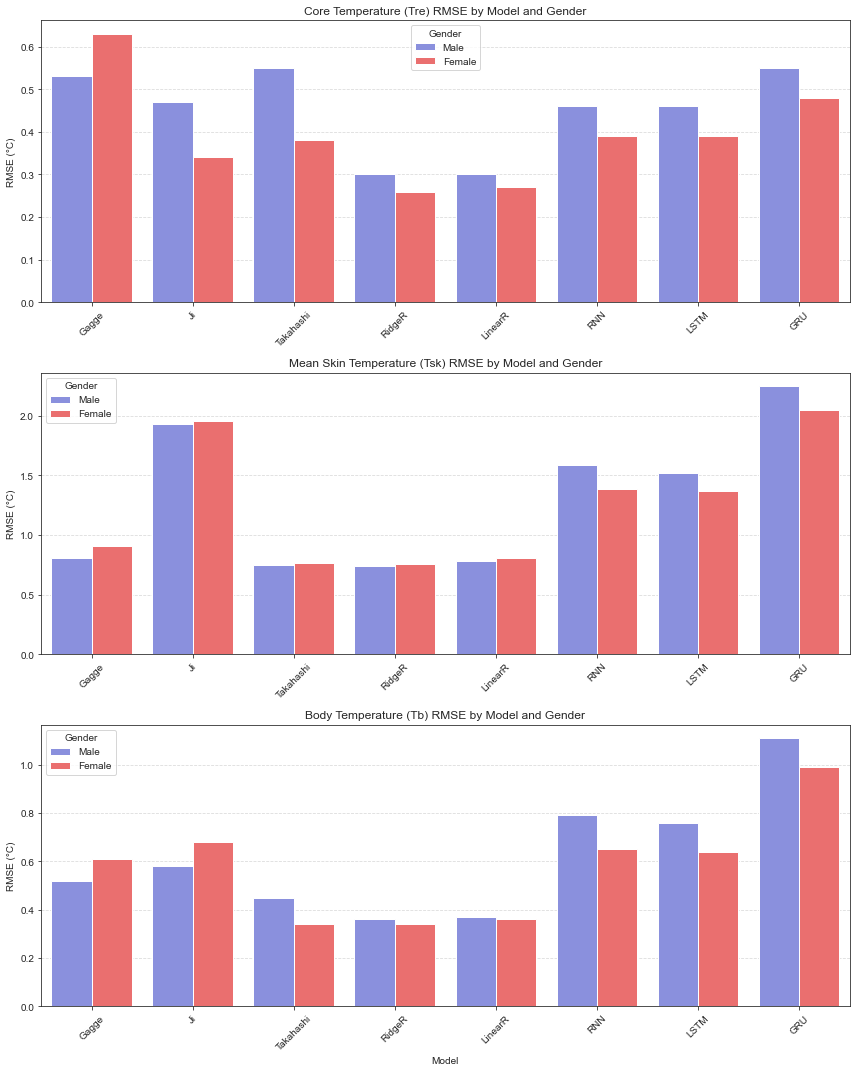

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_rmse_by_gender(merged_samples, models):
    # Set the style
    sns.set_style("ticks")

    # Create lists to store results
    results = []

    # Model name mapping
    model_names = {
        'ji': 'Ji',
        'takahashi': 'Takahashi',
        'gagge': 'Gagge',
        'ml_ridge_regression': 'RidgeR',
        'ml_linear_regression': 'LinearR',
        'ml_rnn': 'RNN',
        'ml_lstm': 'LSTM',
        'ml_gru': 'GRU'
    }

    # Calculate RMSE for each model and gender
    for model in models:
        tre_col = f'tre_predicted_{model}'
        mtsk_col = f'mtsk_predicted_{model}'

        if tre_col in merged_samples.columns and mtsk_col in merged_samples.columns:
            # Calculate for males (female = 0)
            male_data = merged_samples[merged_samples['female'] == 0]
            male_tre_rmse = round(np.sqrt(mean_squared_error(male_data[tre_col], male_data['tre_int'])), 2)
            male_mtsk_rmse = round(np.sqrt(mean_squared_error(male_data[mtsk_col], male_data['mtsk_int'])), 2)
            male_tb_pred = 0.64 * male_data[tre_col] + 0.36 * male_data[mtsk_col]
            male_tb_actual = 0.64 * male_data['tre_int'] + 0.36 * male_data['mtsk_int']
            male_tb_rmse = round(np.sqrt(mean_squared_error(male_tb_pred, male_tb_actual)), 2)

            # Calculate for females (female = 1)
            female_data = merged_samples[merged_samples['female'] == 1]
            female_tre_rmse = round(np.sqrt(mean_squared_error(female_data[tre_col], female_data['tre_int'])), 2)
            female_mtsk_rmse = round(np.sqrt(mean_squared_error(female_data[mtsk_col], female_data['mtsk_int'])), 2)
            female_tb_pred = 0.64 * female_data[tre_col] + 0.36 * female_data[mtsk_col]
            female_tb_actual = 0.64 * female_data['tre_int'] + 0.36 * female_data['mtsk_int']
            female_tb_rmse = round(np.sqrt(mean_squared_error(female_tb_pred, female_tb_actual)), 2)

            # Get proper model name
            display_name = model_names.get(model.lower(), model)

            # Append results
            results.extend([
                {'Model': display_name, 'Metric': 'Tre', 'Gender': 'Male', 'RMSE': male_tre_rmse},
                {'Model': display_name, 'Metric': 'Tre', 'Gender': 'Female', 'RMSE': female_tre_rmse},
                {'Model': display_name, 'Metric': 'Tsk', 'Gender': 'Male', 'RMSE': male_mtsk_rmse},
                {'Model': display_name, 'Metric': 'Tsk', 'Gender': 'Female', 'RMSE': female_mtsk_rmse},
                {'Model': display_name, 'Metric': 'Tb', 'Gender': 'Male', 'RMSE': male_tb_rmse},
                {'Model': display_name, 'Metric': 'Tb', 'Gender': 'Female', 'RMSE': female_tb_rmse}
            ])

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

    # Colors for male and female
    colors = {'Male': '#7c84eb', 'Female': '#FF5A5A'}

    # Plot Tre
    sns.barplot(
        data=results_df[results_df['Metric'] == 'Tre'],
        x='Model',
        y='RMSE',
        hue='Gender',
        palette=colors,
        ax=ax1,
        ci=None
    )
    ax1.set_title('Core Temperature (Tre) RMSE by Model and Gender')
    ax1.set_xlabel('')
    ax1.set_ylabel('RMSE (°C)')
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax1.tick_params(axis='x', rotation=45)

    # Plot Tsk
    sns.barplot(
        data=results_df[results_df['Metric'] == 'Tsk'],
        x='Model',
        y='RMSE',
        hue='Gender',
        palette=colors,
        ax=ax2,
        ci=None
    )
    ax2.set_title('Mean Skin Temperature (Tsk) RMSE by Model and Gender')
    ax2.set_xlabel('')
    ax2.set_ylabel('RMSE (°C)')
    ax2.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax2.tick_params(axis='x', rotation=45)

    # Plot Tb
    sns.barplot(
        data=results_df[results_df['Metric'] == 'Tb'],
        x='Model',
        y='RMSE',
        hue='Gender',
        palette=colors,
        ax=ax3,
        ci=None
    )
    ax3.set_title('Body Temperature (Tb) RMSE by Model and Gender')
    ax3.set_xlabel('Model')
    ax3.set_ylabel('RMSE (°C)')
    ax3.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax3.tick_params(axis='x', rotation=45)

    # Adjust layout
    plt.tight_layout()

    return fig

# Example usage:
fig = plot_rmse_by_gender(merged_samples, models)
plt.show()

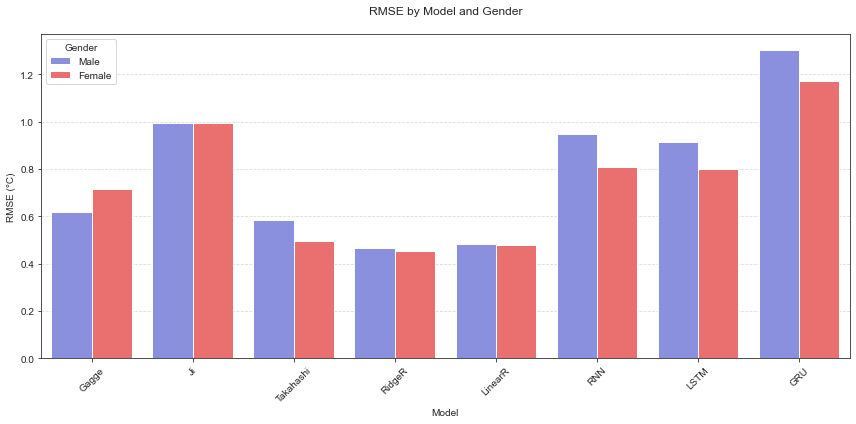

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_rmse_by_gender(merged_samples, models):
    # Set the style
    sns.set_style("ticks")

    # Create lists to store results
    results = []

    # Model name mapping
    model_names = {
        'ji': 'Ji',
        'takahashi': 'Takahashi',
        'gagge': 'Gagge',
        'ml_ridge_regression': 'RidgeR',
        'ml_linear_regression': 'LinearR',
        'ml_rnn': 'RNN',
        'ml_lstm': 'LSTM',
        'ml_gru': 'GRU'
    }

    # Calculate RMSE for each model and gender
    for model in models:
        tre_col = f'tre_predicted_{model}'
        mtsk_col = f'mtsk_predicted_{model}'

        if tre_col in merged_samples.columns and mtsk_col in merged_samples.columns:
            # Calculate for males (female = 0)
            male_data = merged_samples[merged_samples['female'] == 0]
            male_tre_rmse = round(np.sqrt(mean_squared_error(male_data[tre_col], male_data['tre_int'])), 2)
            male_mtsk_rmse = round(np.sqrt(mean_squared_error(male_data[mtsk_col], male_data['mtsk_int'])), 2)
            male_tb_pred = 0.64 * male_data[tre_col] + 0.36 * male_data[mtsk_col]
            male_tb_actual = 0.64 * male_data['tre_int'] + 0.36 * male_data['mtsk_int']
            male_tb_rmse = round(np.sqrt(mean_squared_error(male_tb_pred, male_tb_actual)), 2)

            # Calculate for females (female = 1)
            female_data = merged_samples[merged_samples['female'] == 1]
            female_tre_rmse = round(np.sqrt(mean_squared_error(female_data[tre_col], female_data['tre_int'])), 2)
            female_mtsk_rmse = round(np.sqrt(mean_squared_error(female_data[mtsk_col], female_data['mtsk_int'])), 2)
            female_tb_pred = 0.64 * female_data[tre_col] + 0.36 * female_data[mtsk_col]
            female_tb_actual = 0.64 * female_data['tre_int'] + 0.36 * female_data['mtsk_int']
            female_tb_rmse = round(np.sqrt(mean_squared_error(female_tb_pred, female_tb_actual)), 2)

            # Get proper model name
            display_name = model_names.get(model.lower(), model)

            # Append results
            results.extend([
                {'Model': display_name, 'Metric': 'Tre', 'Gender': 'Male', 'RMSE': male_tre_rmse},
                {'Model': display_name, 'Metric': 'Tre', 'Gender': 'Female', 'RMSE': female_tre_rmse},
                {'Model': display_name, 'Metric': 'Tsk', 'Gender': 'Male', 'RMSE': male_mtsk_rmse},
                {'Model': display_name, 'Metric': 'Tsk', 'Gender': 'Female', 'RMSE': female_mtsk_rmse},
                {'Model': display_name, 'Metric': 'Tb', 'Gender': 'Male', 'RMSE': male_tb_rmse},
                {'Model': display_name, 'Metric': 'Tb', 'Gender': 'Female', 'RMSE': female_tb_rmse}
            ])

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot using seaborn with specified colors
    ax = sns.barplot(
        data=results_df,
        x='Model',
        y='RMSE',
        hue='Gender',
        palette=['#7c84eb', '#FF5A5A'],  # Updated colors
        alpha=1,  # Set alpha to 1
        ci=None
    )

    # Customize the plot
    plt.title('RMSE by Model and Gender', pad=20)
    plt.xlabel('Model')
    plt.ylabel('RMSE (°C)')

    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)

    # Add grid
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()

    return plt.gcf()

# Example usage:
fig = plot_rmse_by_gender(merged_samples, models)
plt.show()

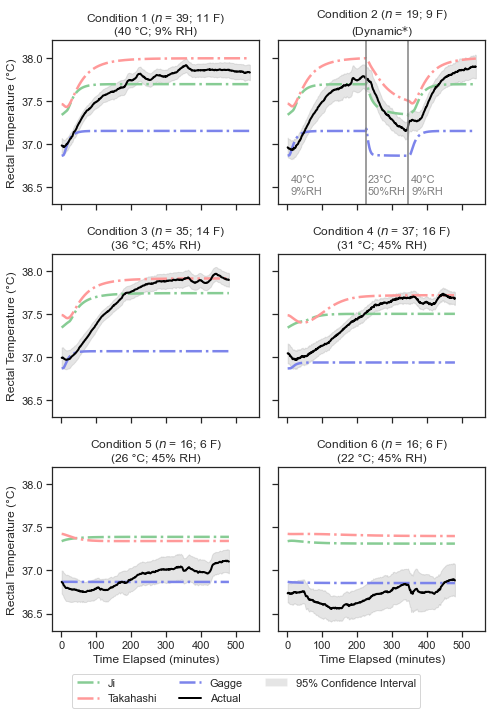

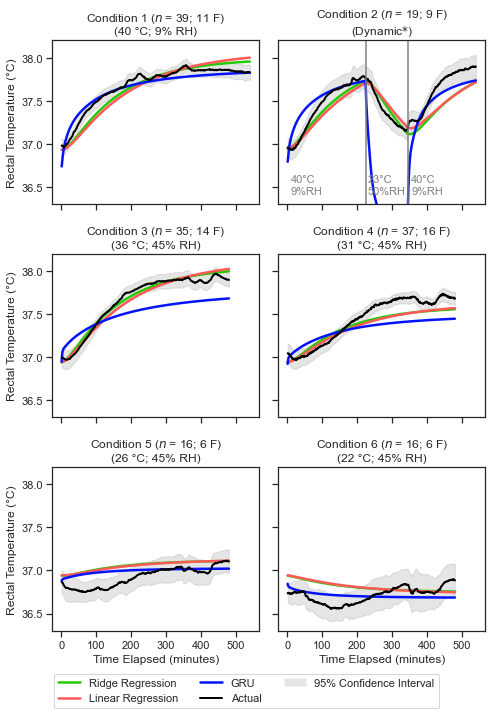

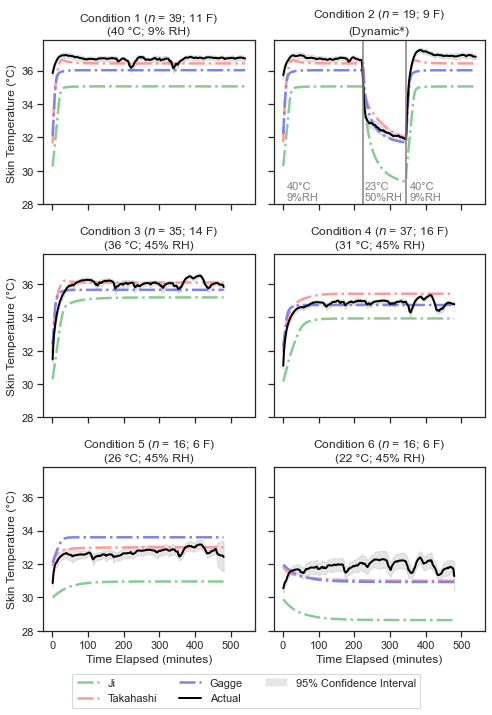

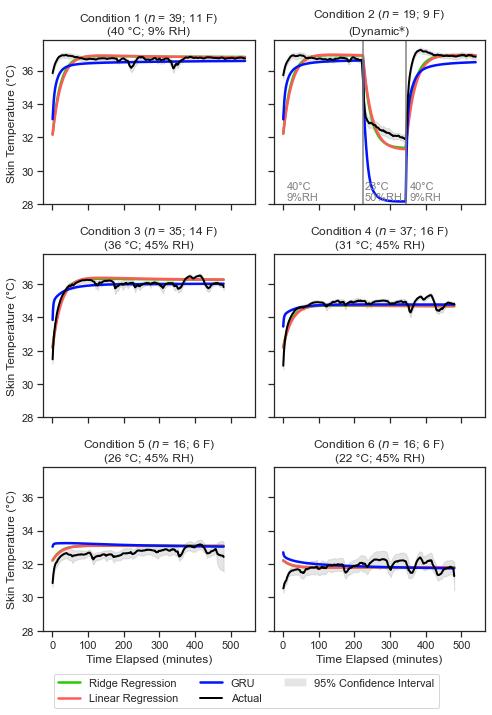

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

legend_labels = {
    'ji': 'Ji',
    'takahashi': 'Takahashi',
    'gagge': 'Gagge',
    'ml_ridge_regression': 'Ridge Regression',
    'ml_linear_regression': 'Linear Regression',
    'ml_gru': 'GRU',
}

def plot_models(samples, models, temp_type='tre', line_style='-', colors=['#25CB00', '#FF5A5A', '#0313fc']):
    temp_column = f'{temp_type}_int'
    sns.set(style="ticks")
    sns.set_palette(sns.color_palette(colors))

    rows, cols = 3, 2
    fig, axs = plt.subplots(rows, cols, figsize=(7, 10), sharex=True, sharey=True)
    axs = axs.flatten()

    handles = []
    labels = [legend_labels[model] for model in models] + ["Actual"]

    for idx, sample in enumerate(samples):
        study = sample.study.iloc[0]
        condition = sample.condition.iloc[0]
        sample = sample[sample.age >= 60]

        # Count males and females
        n_females = len(sample[sample.female == 1].id_all.unique())

        sample_grouped = sample.groupby('time').mean()
        sample_grouped_ci = sample.groupby('time').agg({temp_column: ['mean', 'sem']})

        # Calculate the 95% confidence interval
        sample_grouped_ci[temp_column, 'ci_lower'] = sample_grouped_ci[temp_column]['mean'] - 1.96 * sample_grouped_ci[temp_column]['sem']
        sample_grouped_ci[temp_column, 'ci_upper'] = sample_grouped_ci[temp_column]['mean'] + 1.96 * sample_grouped_ci[temp_column]['sem']

        # Plotting the predicted data
        for model in models:
            model_column = f'{temp_type}_predicted_{model}'
            if model_column in sample_grouped.columns:
                line, = axs[idx].plot(sample_grouped.index, sample_grouped[model_column], linewidth=2.5, linestyle=line_style)
                # Append the line handle and label to the lists
                if idx == 0:
                    handles.append(line)
            else:
                print(f"Column {model_column} not found in {study} {condition} dataframe.")

        # Plotting the actual data
        line, = axs[idx].plot(sample_grouped.index, sample_grouped[temp_column], linewidth=2, color="black")
        if idx == 0:
            handles.append(line)

        # Plot 95% confidence interval as shaded area
        axs[idx].fill_between(sample_grouped.index,
                              sample_grouped_ci[temp_column, 'ci_lower'],
                              sample_grouped_ci[temp_column, 'ci_upper'],
                              color='gray', alpha=0.2)

        # Updated title with gender breakdown
        if idx != 1:  # For regular conditions
            axs[idx].set_title('Condition {} ($n$ = {}; {} F)\n({} °C; {}% RH)'.format(
                idx+1, len(sample.id_all.unique()), n_females,
                sample.ta_set.iloc[0], sample.rh_set.iloc[0]
            ))
        else:  # For the dynamic condition
            axs[idx].set_title('Condition {} ($n$ = {}; {} F)\n(Dynamic$*$)'.format(
                idx+1, len(sample.id_all.unique()), n_females
            ))
            axs[idx].axvline(225, color="grey")
            axs[idx].axvline(225+120, color="grey")
            y_min = axs[idx].get_ylim()[0]
            axs[idx].text(0+10, y_min+0.1, '40°C\n9%RH', verticalalignment='bottom', horizontalalignment='left', color="grey", size=11)
            axs[idx].text(225+5, y_min+0.1, '23°C\n50%RH', verticalalignment='bottom', horizontalalignment='left', color="grey", size=11)
            axs[idx].text(225+120+10, y_min+0.1, '40°C\n9%RH', verticalalignment='bottom', horizontalalignment='left', color="grey", size=11)

        if temp_type == 'tre':
            axs[idx].set_ylim(36.3, 38.2)
        else:
            axs[idx].set_ylim(28.0, 37.8)

        if idx % cols != 0:
            axs[idx].set_ylabel("")
        else:
            axs[idx].set_ylabel(f"{'Rectal' if temp_column == 'tre_int' else 'Skin'} Temperature (°C)")

        if idx < (rows - 1) * cols:
            axs[idx].set_xlabel("")
        else:
            axs[idx].set_xlabel("Time Elapsed (minutes)")

    # Create a handle and label for the 95% confidence interval shaded area
    ci_handle = plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.2)
    ci_label = '95% Confidence Interval'
    handles.append(ci_handle)
    labels.append(ci_label)

    for idx_unused in range(len(samples), rows*cols):
        fig.delaxes(axs[idx_unused])

    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=3)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(f"figures/{temp_type}_line_chart_{'ml' if 'ml' in models[0] else 'biophysical'}.pdf")
    plt.show()

# Biophysical models
biophysical_models = ['ji', 'takahashi', 'gagge']

# ML models
ml_models = ['ml_ridge_regression', 'ml_linear_regression', 'ml_gru']

# Plot rectal temperature for biophysical models
plot_models(samples, biophysical_models, temp_type='tre', line_style='-.', colors=['#87CC94', '#FF9999', '#7c84eb'])

# Plot rectal temperature for ML models
plot_models(samples, ml_models, temp_type='tre', line_style='-', colors=['#25CB00', '#FF5A5A', '#0313fc'])

# Plot skin temperature for biophysical models
plot_models(samples, biophysical_models, temp_type='mtsk', line_style='-.', colors=['#87CC94', '#FF9999', '#7c84eb'])

# Plot skin temperature for ML models
plot_models(samples, ml_models, temp_type='mtsk', line_style='-', colors=['#25CB00', '#FF5A5A', '#0313fc'])

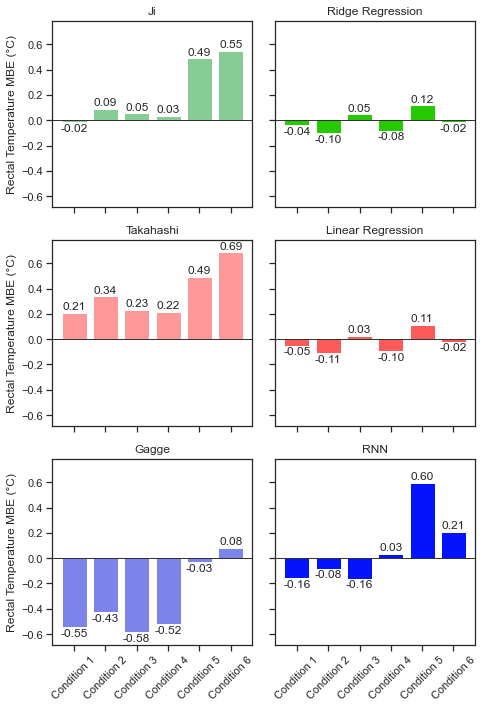

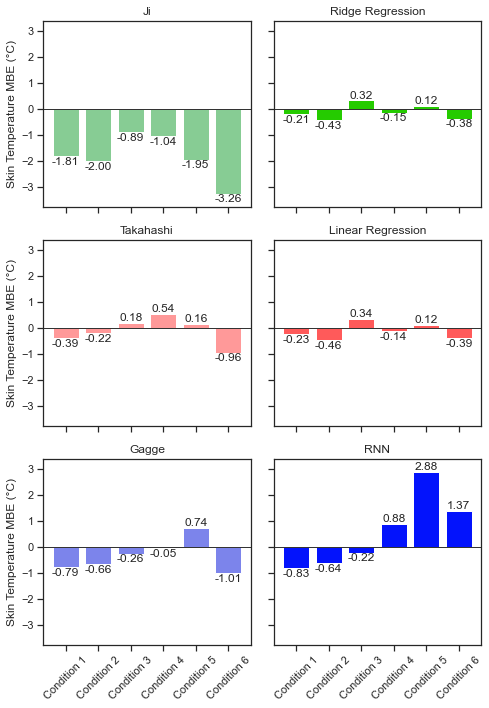

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_mbe(actual, predicted):
    return np.mean(predicted - actual)

def plot_mbe(samples, models, model_labels, model_colors, temp_type='tre'):
    rows, cols = 3, 2
    fig, axs = plt.subplots(rows, cols, figsize=(7, 10), sharex=True, sharey=True)
    axs = axs.flatten()

    global_min_mbe = float('inf')
    global_max_mbe = float('-inf')

    for idx, model in enumerate(models):
        mbe_values = []
        for sample in samples:
            actual = sample[f'{temp_type}_int']
            predicted = sample[f'{temp_type}_predicted_{model}']
            mbe = calculate_mbe(actual, predicted)
            mbe_values.append(mbe)
            global_min_mbe = min(global_min_mbe, mbe)
            global_max_mbe = max(global_max_mbe, mbe)

        bars = axs[idx].bar(range(1, len(samples) + 1), mbe_values, color=model_colors[idx])
        axs[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        axs[idx].set_title(model_labels[idx])
        axs[idx].set_xticks(range(1, len(samples) + 1))
        axs[idx].set_xticklabels([f'Condition {i+1}' for i in range(len(samples))])
        axs[idx].tick_params(axis='x', rotation=45)

        for bar, mbe in zip(bars, mbe_values):
            height = bar.get_height()
            if mbe >= 0:
                axs[idx].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{mbe:.2f}', ha='center', va='bottom', fontsize=12)
            else:
                axs[idx].text(bar.get_x() + bar.get_width() / 2, height - 0.01, f'{mbe:.2f}', ha='center', va='top', fontsize=12)

        if idx % cols == 0:
            if temp_type == 'tre':
                axs[idx].set_ylabel('Rectal Temperature MBE (°C)')
            else:
                axs[idx].set_ylabel('Skin Temperature MBE (°C)')

    # Set y-axis limits with extra room based on global minimum and maximum MBE values
    offset = 0.5
    if temp_type == 'tre':
        offset = 0.1
    y_min = global_min_mbe - offset
    y_max = global_max_mbe + offset
    for ax in axs:
        ax.set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.savefig(f"figures/{temp_type}_mbe_barchart.pdf", format='pdf', dpi=300)
    plt.show()

# Example usage
# models = ['ji', 'takahashi', 'gagge', 'ml_ridge_regression', 'ml_linear_regression', 'ml_gru']
# model_labels = ['Ji', 'Takahashi', 'Gagge', 'Ridge Regression', 'Linear Regression', 'GRU']
# model_colors = ['#87CC94', '#FF9999', '#7c84eb', '#25CB00', '#FF5A5A', '#0313fc']

models = ['ji', 'ml_ridge_regression', 'takahashi', 'ml_linear_regression', 'gagge', 'ml_rnn']
model_labels = ['Ji', 'Ridge Regression', 'Takahashi', 'Linear Regression', 'Gagge', 'RNN']
model_colors = ['#87CC94', '#25CB00', '#FF9999', '#FF5A5A', '#7c84eb', '#0313fc']

# Plot MBE for rectal temperature (tre)
plot_mbe(samples, models, model_labels, model_colors, temp_type='tre')

# Plot MBE for mean skin temperature (mtsk)
plot_mbe(samples, models, model_labels, model_colors, temp_type='mtsk')

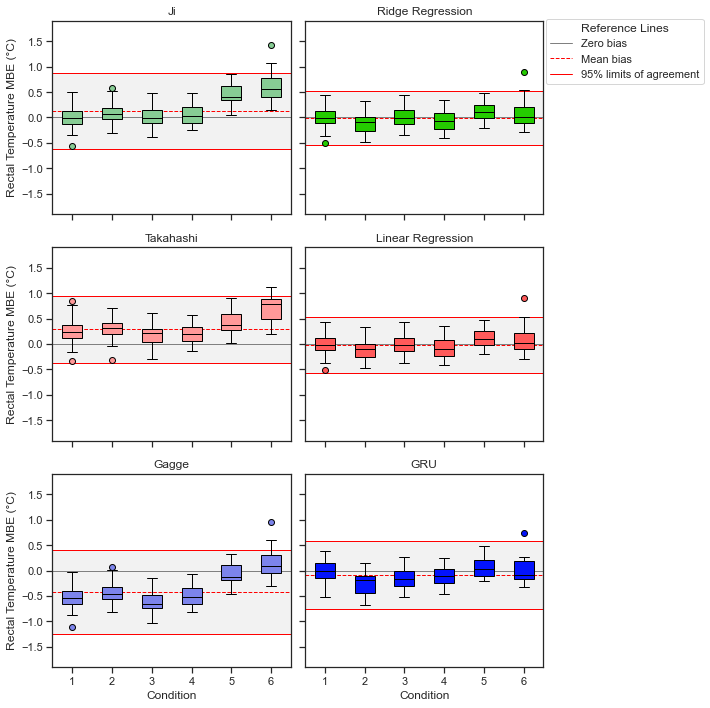

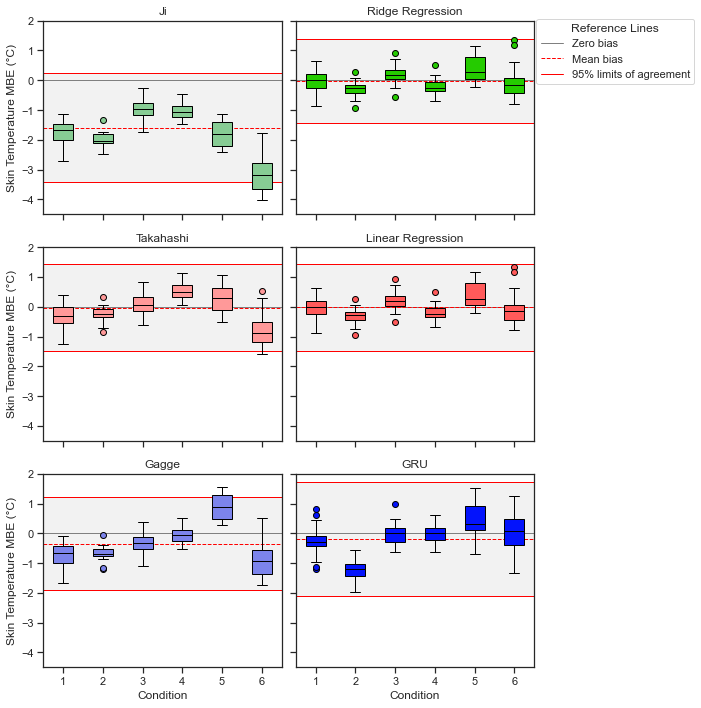

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_mbe(actual, predicted):
    return np.mean(predicted - actual)

def calculate_limits_of_agreement(actual, predicted):
    differences = predicted - actual
    mean_diff = np.mean(differences)
    std_diff = np.std(differences)
    upper_limit = mean_diff + 1.96 * std_diff
    lower_limit = mean_diff - 1.96 * std_diff
    return lower_limit, mean_diff, upper_limit

def plot_mbe(samples, models, model_labels, model_colors, temp_type='tre', tick_space=0.5):
    rows, cols = 3, 2
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10), sharex=True, sharey=True)
    axs = axs.flatten()

    global_min_mbe = float('inf')
    global_max_mbe = float('-inf')

    for idx, model in enumerate(models):
        mbe_values_per_condition = [[] for _ in range(len(samples))]

        for sample_idx, sample in enumerate(samples):
            individuals = sample['id'].unique()
            for ind in individuals:
                actual = sample[sample['id'] == ind][f'{temp_type}_int']
                predicted = sample[sample['id'] == ind][f'{temp_type}_predicted_{model}']
                mbe = calculate_mbe(actual, predicted)
                mbe_values_per_condition[sample_idx].append(mbe)
                global_min_mbe = min(global_min_mbe, mbe)
                global_max_mbe = max(global_max_mbe, mbe)

        axs[idx].boxplot(mbe_values_per_condition, positions=range(1, len(samples) + 1), widths=0.5,
                         patch_artist=True,
                         boxprops=dict(facecolor=model_colors[idx], color='black'),
                         whiskerprops=dict(color='black'),
                         capprops=dict(color='black'),
                         flierprops=dict(marker='o', color=model_colors[idx], markerfacecolor=model_colors[idx], alpha=1),
                         medianprops=dict(color='black'),
                         zorder=2)

        axs[idx].set_title(model_labels[idx])

        # Modified x-axis ticks and labels
        axs[idx].set_xticks(range(1, len(samples) + 1))
        axs[idx].set_xticklabels([str(i) for i in range(1, len(samples) + 1)])

        # Add x-axis label for bottom plots
        if idx >= len(models) - cols:  # Only for bottom row
            axs[idx].set_xlabel('Condition')

        y_min = global_min_mbe
        y_max = global_max_mbe

        y_min = np.floor(y_min * 2) / 2
        y_max = np.ceil(y_max * 2) / 2

    legend_lines = []
    legend_labels = []

    for idx, model in enumerate(models):
        all_actual = np.concatenate([sample[f'{temp_type}_int'] for sample in samples])
        all_predicted = np.concatenate([sample[f'{temp_type}_predicted_{model}'] for sample in samples])
        lower, mean, upper = calculate_limits_of_agreement(all_actual, all_predicted)

        axs[idx].fill_between(axs[idx].get_xlim(), lower, upper, color='grey', alpha=0.1, zorder=0)

        zero_line = axs[idx].axhline(y=0, color='grey', linestyle='-', linewidth=1, zorder=1)
        upper_line = axs[idx].axhline(y=upper, color='red', linestyle='-', linewidth=1, zorder=1)
        mean_line = axs[idx].axhline(y=mean, color='red', linestyle='--', linewidth=1, zorder=1)
        lower_line = axs[idx].axhline(y=lower, color='red', linestyle='-', linewidth=1, zorder=1)

        if idx == 0:
            legend_lines.extend([zero_line, mean_line, upper_line])
            legend_labels.extend(['Zero bias', 'Mean bias', '95% limits of agreement'])  # Modified legend label

        if idx % cols == 0:
            if temp_type == 'tre':
                axs[idx].set_ylabel('Rectal Temperature MBE (°C)')
                axs[idx].set_ylim(y_min - 0.4, y_max + 0.4)
            else:
                axs[idx].set_ylabel('Skin Temperature MBE (°C)')
                axs[idx].set_ylim(y_min, y_max)

    plt.tight_layout()

    fig.subplots_adjust(right=0.75)
    fig.legend(legend_lines, legend_labels,
              loc='center right',
              bbox_to_anchor=(0.98, 0.92),
              title='Reference Lines')

    plt.savefig(f"figures/{temp_type}_mbe_boxplot.pdf", bbox_inches='tight')
    plt.show()

models = ['ji', 'ml_ridge_regression', 'takahashi', 'ml_linear_regression', 'gagge', 'ml_gru']
model_labels = ['Ji', 'Ridge Regression', 'Takahashi', 'Linear Regression', 'Gagge', 'GRU']
model_colors = ['#87CC94', '#25CB00', '#FF9999', '#FF5A5A', '#7c84eb', '#0313fc']

# Plot MBE for rectal temperature (tre)
plot_mbe(samples, models, model_labels, model_colors, temp_type='tre')

# Plot MBE for mean skin temperature (mtsk)
plot_mbe(samples, models, model_labels, model_colors, temp_type='mtsk', tick_space=1)

In [11]:
import numpy as np
import pandas as pd

def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((predicted - actual) ** 2))

def calculate_rmse_proportion(samples, models, model_labels, rmse_threshold=0.5, temp_type='tre'):
    results = {label: [] for label in model_labels}

    for idx, model in enumerate(models):
        total_participants = 0
        for sample in samples:
            rmse_values = []
            individuals = sample['id'].unique()
            for ind in individuals:
                actual = sample[sample['id'] == ind][f'{temp_type}_int']
                predicted = sample[sample['id'] == ind][f'{temp_type}_predicted_{model}']
                rmse = calculate_rmse(actual, predicted)
                rmse_values.append(rmse)

            # Calculate proportion of participants with RMSE < rmse_threshold
            count = np.sum(np.array(rmse_values) < rmse_threshold)
            number_participants = len(sample['id'].unique())
            total_participants += number_participants
            results[model_labels[idx]].append(f"{count}/{number_participants}")

    # Convert results to DataFrame for easier handling
    df = pd.DataFrame(results, index=[f'Condition {i+1}' for i in range(len(samples))])

    # Calculate overall proportion
    overall = {label: [] for label in model_labels}
    for label in model_labels:
        total_count = sum(int(value.split('/')[0]) for value in results[label])
        overall[label].append(f"{total_count}/{total_participants}")

    # Append overall row
    overall_df = pd.DataFrame(overall, index=['Overall'])
    df = pd.concat([df, overall_df])

    # Transpose the DataFrame
    df_transposed = df.T

    # Generate LaTeX table
    latex_table = df.to_latex(index=True)
    return latex_table

# Example usage
models = ['ji', 'takahashi', 'gagge', 'ml_ridge_regression', 'ml_linear_regression', 'ml_gru', 'ml_rnn', 'ml_lstm']
model_labels = ['Ji', 'Takahashi', 'Gagge', 'Ridge Regression', 'Linear Regression', 'GRU', 'RNN', 'LSTM']

# Calculate RMSE proportion for rectal temperature (tre)
latex_table_tre = calculate_rmse_proportion(samples, models, model_labels, rmse_threshold=0.3, temp_type='tre')
print(latex_table_tre)

# Calculate RMSE proportion for mean skin temperature (mtsk)
latex_table_mtsk = calculate_rmse_proportion(samples, models, model_labels, rmse_threshold=1, temp_type='mtsk')
print(latex_table_mtsk)

/var/folders/8q/byh6pjkx74d7p_crfrzgdpbd2xgt0t/T/ipykernel_51887/1143969510.py:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=True)


\begin{tabular}{lllllllll}
\toprule
{} &      Ji & Takahashi &   Gagge & Ridge Regression & Linear Regression &     GRU &     RNN &    LSTM \\
\midrule
Condition 1 &   24/39 &     18/39 &    3/39 &            30/39 &             29/39 &   28/39 &   15/39 &   17/39 \\
Condition 2 &    9/19 &      3/19 &    3/19 &            12/19 &             12/19 &    0/19 &    7/19 &    8/19 \\
Condition 3 &   19/35 &     16/35 &    0/35 &            26/35 &             25/35 &   18/35 &    5/35 &    6/35 \\
Condition 4 &   18/37 &     17/37 &    2/37 &            26/37 &             26/37 &   22/37 &    8/37 &    8/37 \\
Condition 5 &    2/16 &      2/16 &   10/16 &            10/16 &             10/16 &   11/16 &    8/16 &    8/16 \\
Condition 6 &    2/16 &      0/16 &    9/16 &            10/16 &             10/16 &   11/16 &    7/16 &    6/16 \\
Overall     &  74/162 &    56/162 &  27/162 &          114/162 &           112/162 &  90/162 &  50/162 &  53/162 \\
\bottomrule
\end{tabular}

\begin{ta

/var/folders/8q/byh6pjkx74d7p_crfrzgdpbd2xgt0t/T/ipykernel_51887/1143969510.py:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=True)


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_mbe(actual, predicted):
    return np.mean(predicted - actual)


def generate_latex_table(samples, models, model_labels, temp_type='tre'):
    table = "\\begin{table}[]\n"
    table += "\\centering\n"
    table += "\\begin{tabular}{" + "l" * (len(samples) + 1) + "}\n"
    table += "\\hline\n"
    table += "Model & " + " & ".join(f"Condition {i+1}" for i in range(len(samples))) + " \\\\\n"
    table += "\\hline\n"

    for idx, model in enumerate(models):
        mbe_values = []
        for sample in samples:
            actual = sample[f'{temp_type}_int']
            predicted = sample[f'{temp_type}_predicted_{model}']
            mbe = calculate_mbe(actual, predicted)
            mbe_values.append(f"{mbe:.2f}")

        table += f"{model_labels[idx]} & " + " & ".join(mbe_values) + " \\\\\n"

    table += "\\hline\n"
    table += "\\end{tabular}\n"
    table += f"\\caption{{MBE results for {temp_type} temperature}}\n"
    table += f"\\label{{tab:{temp_type}_mbe}}\n"
    table += "\\end{table}\n"

    return table

# Example usage
models = ['ji', 'ml_ridge_regression', 'takahashi', 'ml_linear_regression', 'gagge', 'ml_gru']
model_labels = ['Ji', 'Ridge Regression', 'Takahashi', 'Linear Regression', 'Gagge', 'GRU']
model_colors = ['#87CC94', '#25CB00', '#FF9999', '#FF5A5A', '#7c84eb', '#0313fc']

# Generate LaTeX table for rectal temperature (tre)
tre_table = generate_latex_table(samples, models, model_labels, temp_type='tre')
print("Rectal Temperature MBE Table:")
print(tre_table)

# Generate LaTeX table for mean skin temperature (mtsk)
mtsk_table = generate_latex_table(samples, models, model_labels, temp_type='mtsk')
print("Mean Skin Temperature MBE Table:")
print(mtsk_table)

Rectal Temperature MBE Table:
\begin{table}[]
\centering
\begin{tabular}{lllllll}
\hline
Model & Condition 1 & Condition 2 & Condition 3 & Condition 4 & Condition 5 & Condition 6 \\
\hline
Ji & -0.02 & 0.09 & 0.05 & 0.03 & 0.49 & 0.55 \\
Ridge Regression & -0.04 & -0.10 & 0.05 & -0.08 & 0.12 & -0.02 \\
Takahashi & 0.21 & 0.34 & 0.23 & 0.22 & 0.49 & 0.69 \\
Linear Regression & -0.05 & -0.11 & 0.03 & -0.10 & 0.11 & -0.02 \\
Gagge & -0.55 & -0.43 & -0.58 & -0.52 & -0.03 & 0.08 \\
GRU & -0.02 & -0.25 & 0.03 & 0.23 & 0.75 & -0.82 \\
\hline
\end{tabular}
\caption{MBE results for tre temperature}
\label{tab:tre_mbe}
\end{table}

Mean Skin Temperature MBE Table:
\begin{table}[]
\centering
\begin{tabular}{lllllll}
\hline
Model & Condition 1 & Condition 2 & Condition 3 & Condition 4 & Condition 5 & Condition 6 \\
\hline
Ji & -1.81 & -2.00 & -0.89 & -1.04 & -1.95 & -3.26 \\
Ridge Regression & -0.21 & -0.43 & 0.32 & -0.15 & 0.12 & -0.38 \\
Takahashi & -0.39 & -0.22 & 0.18 & 0.54 & 0.16 & -0.96 \\


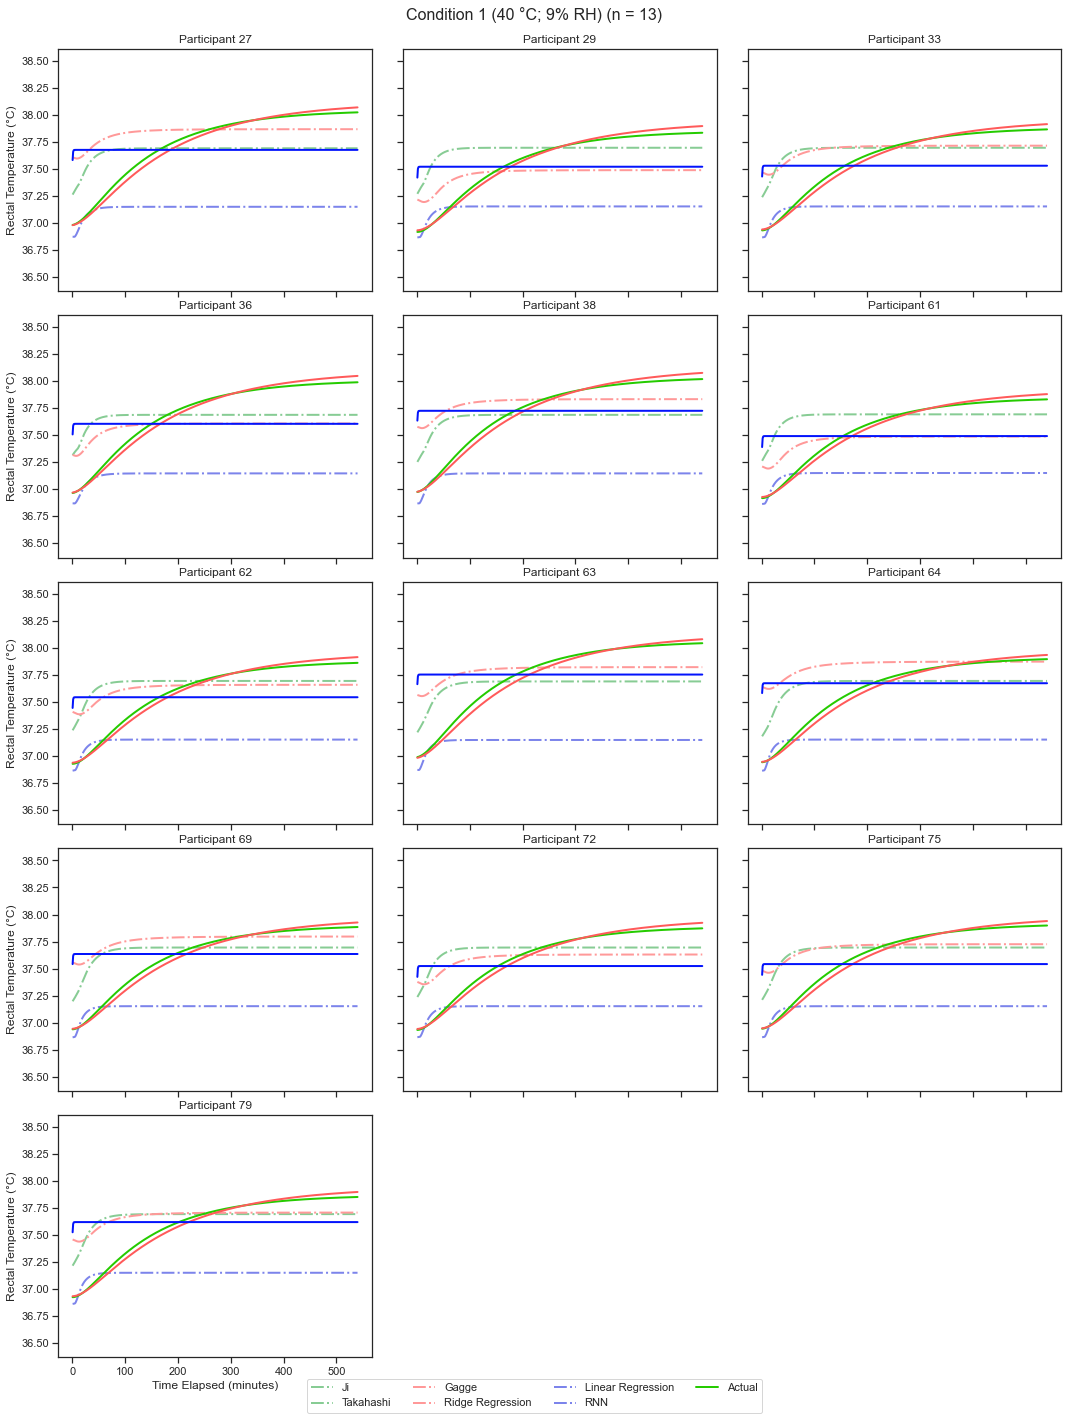

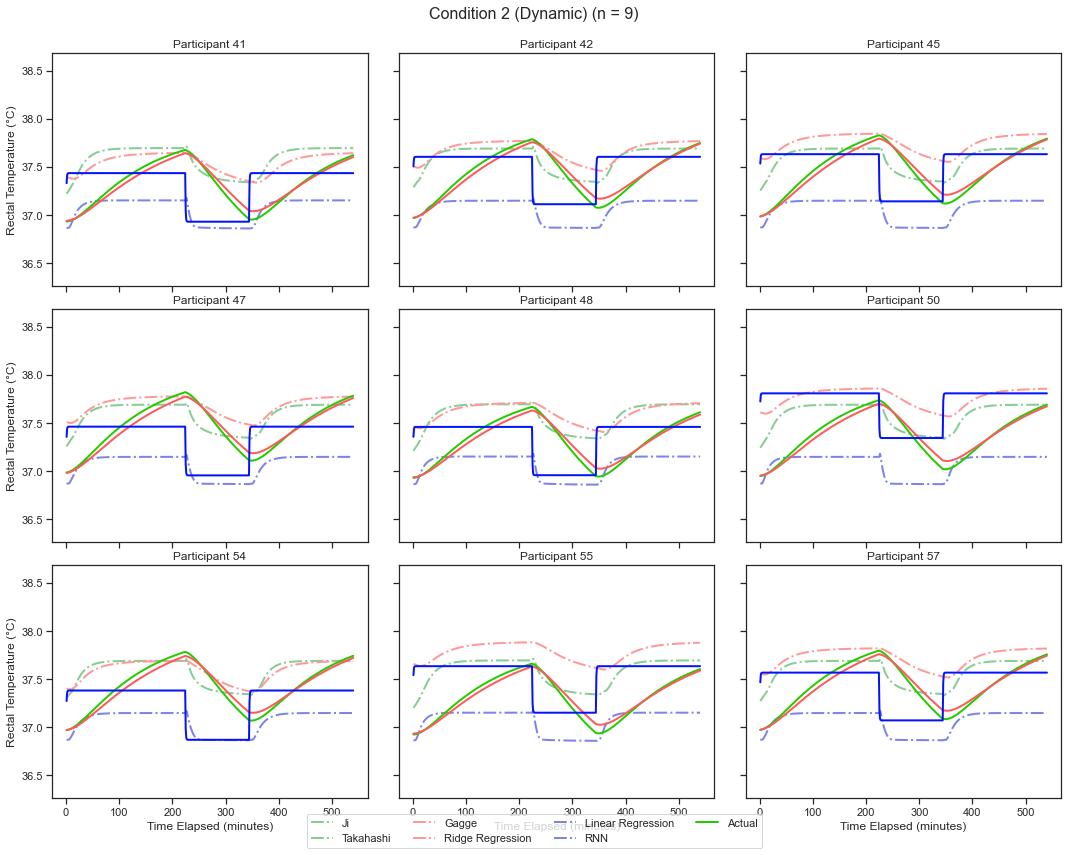

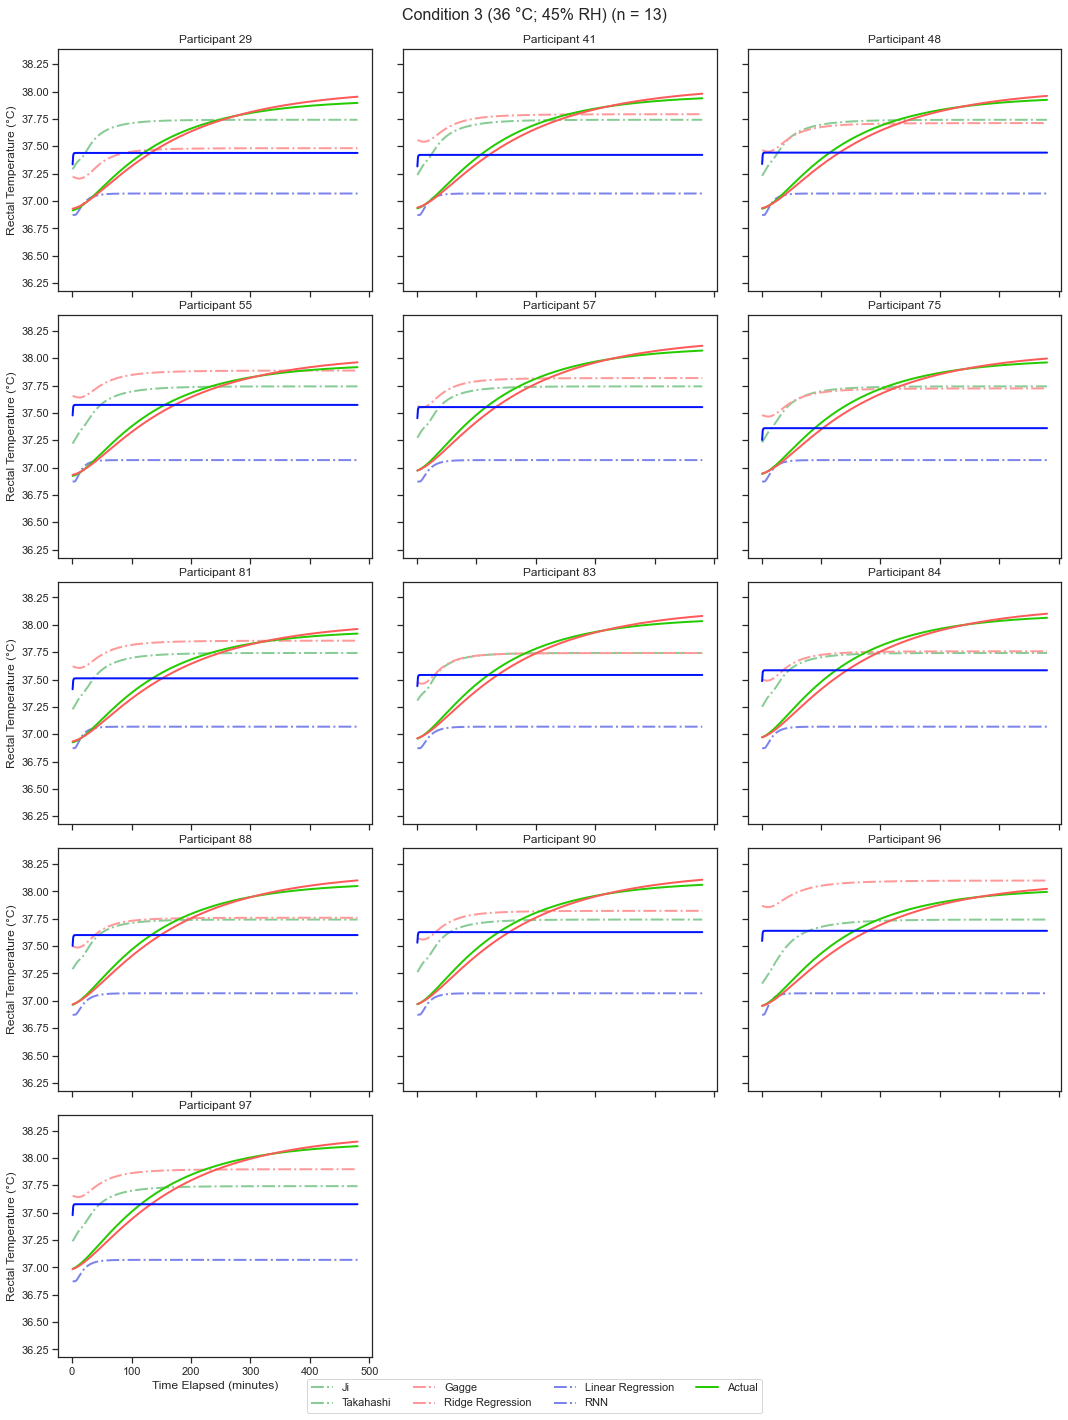

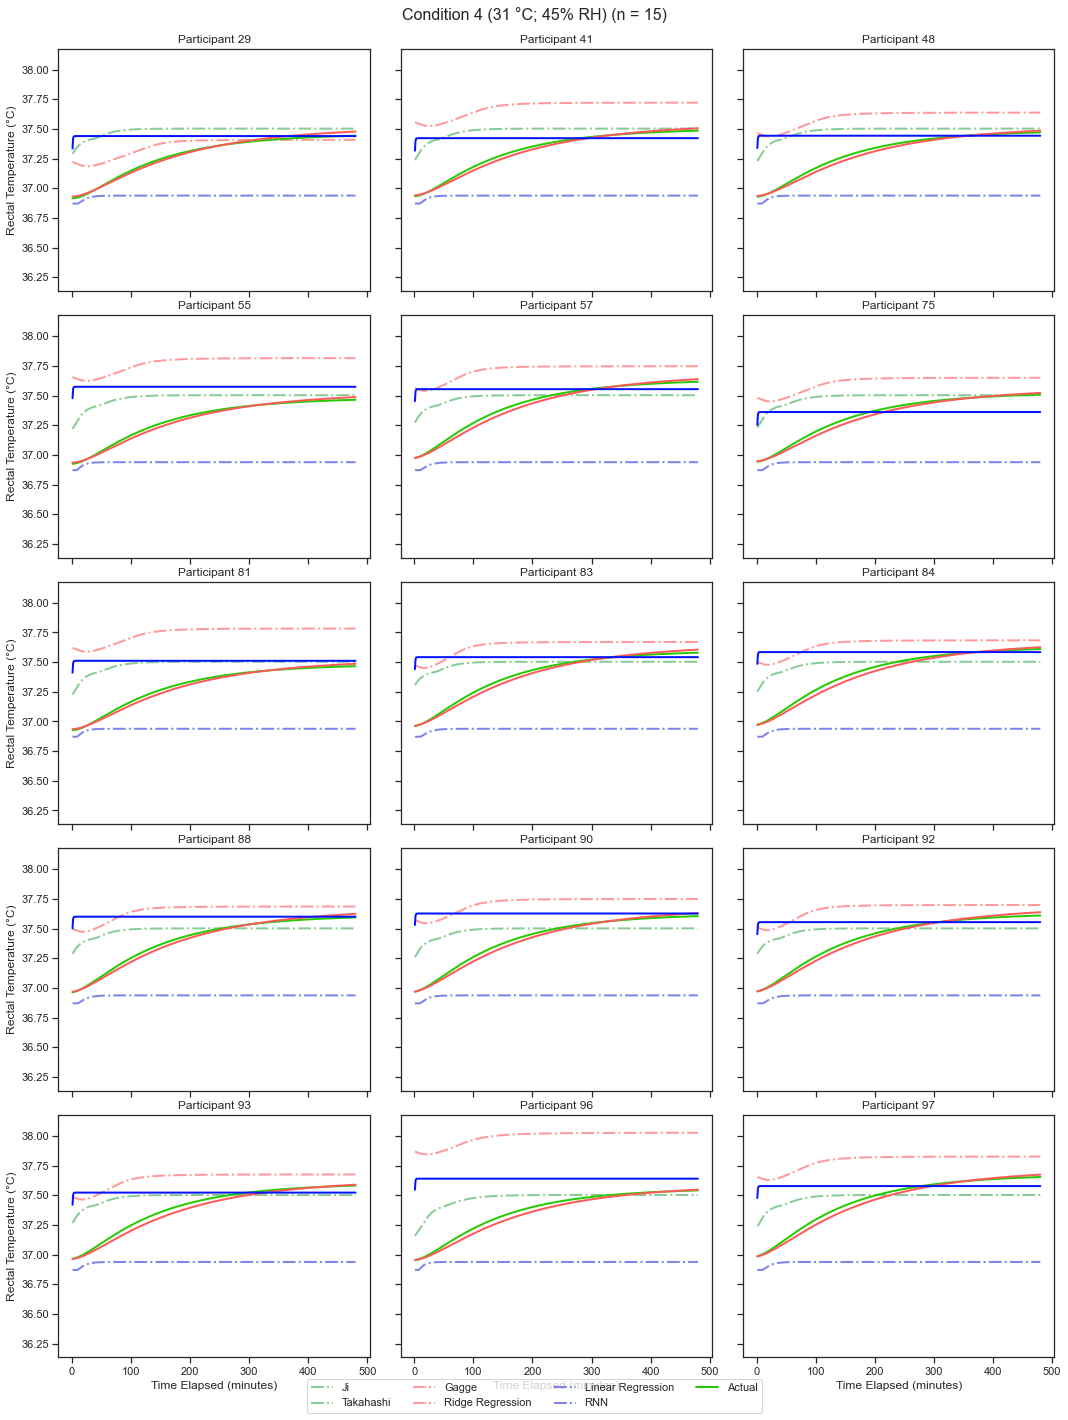

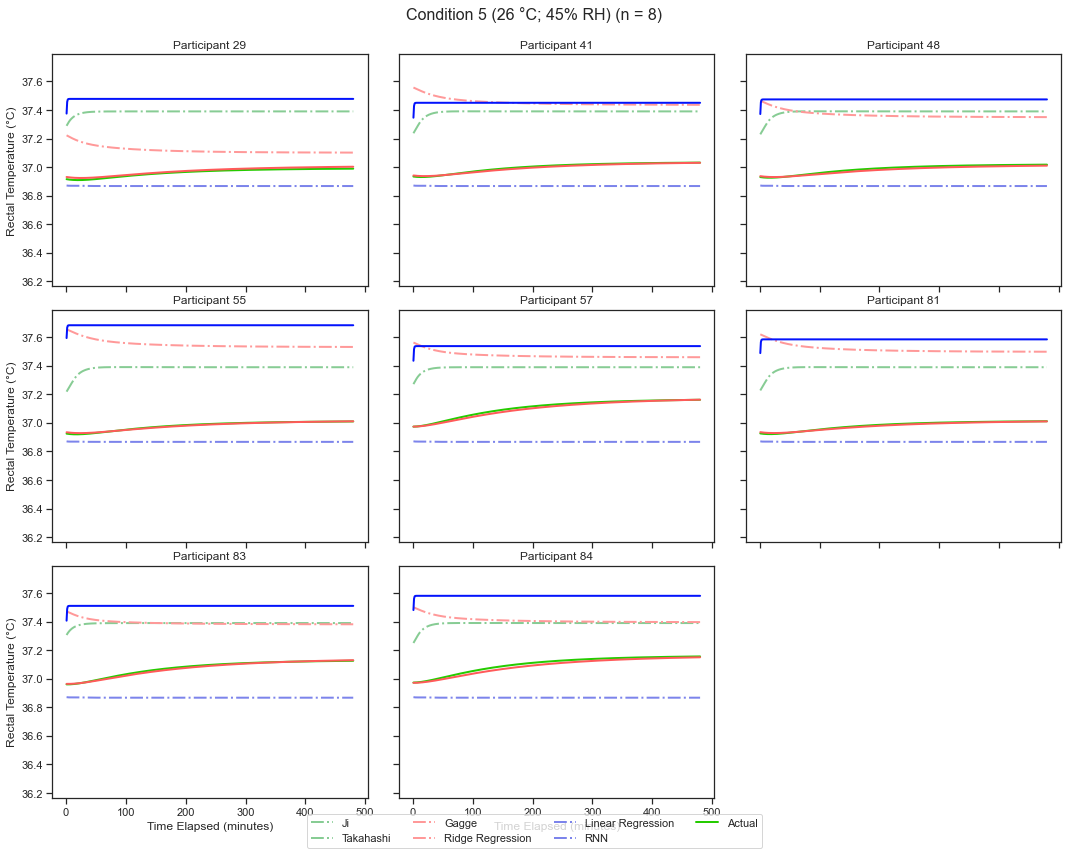

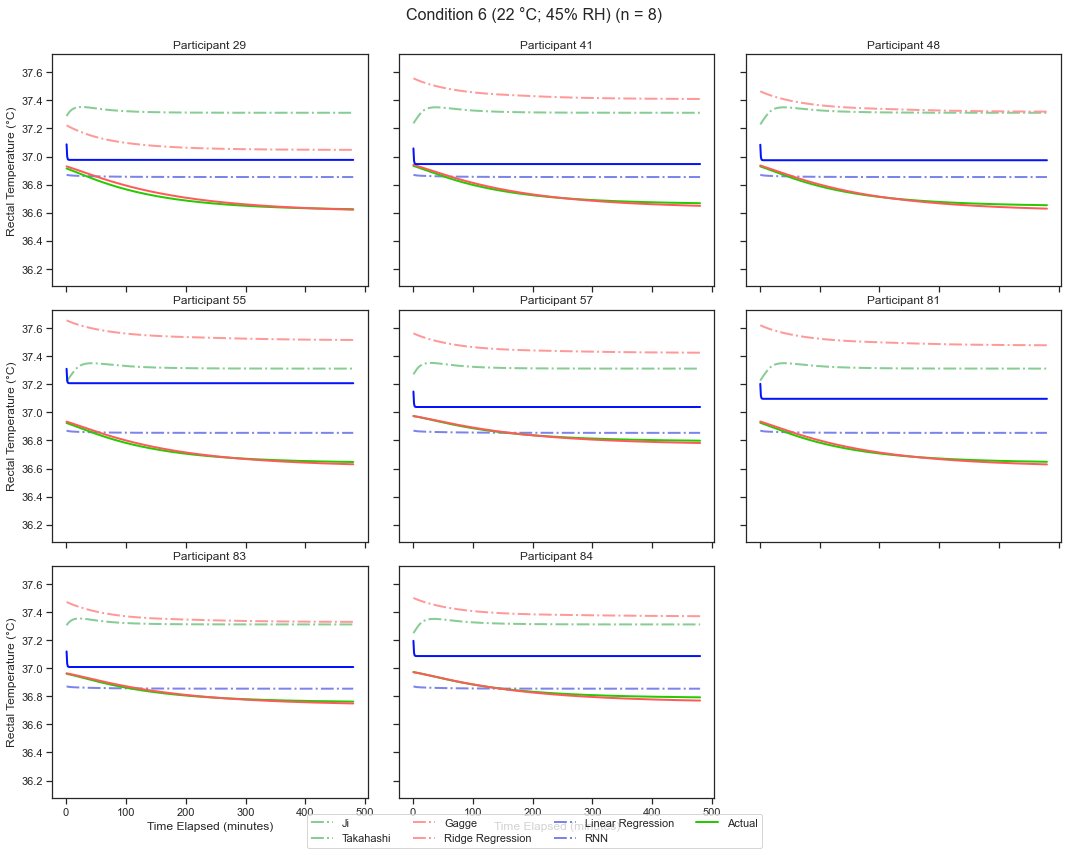

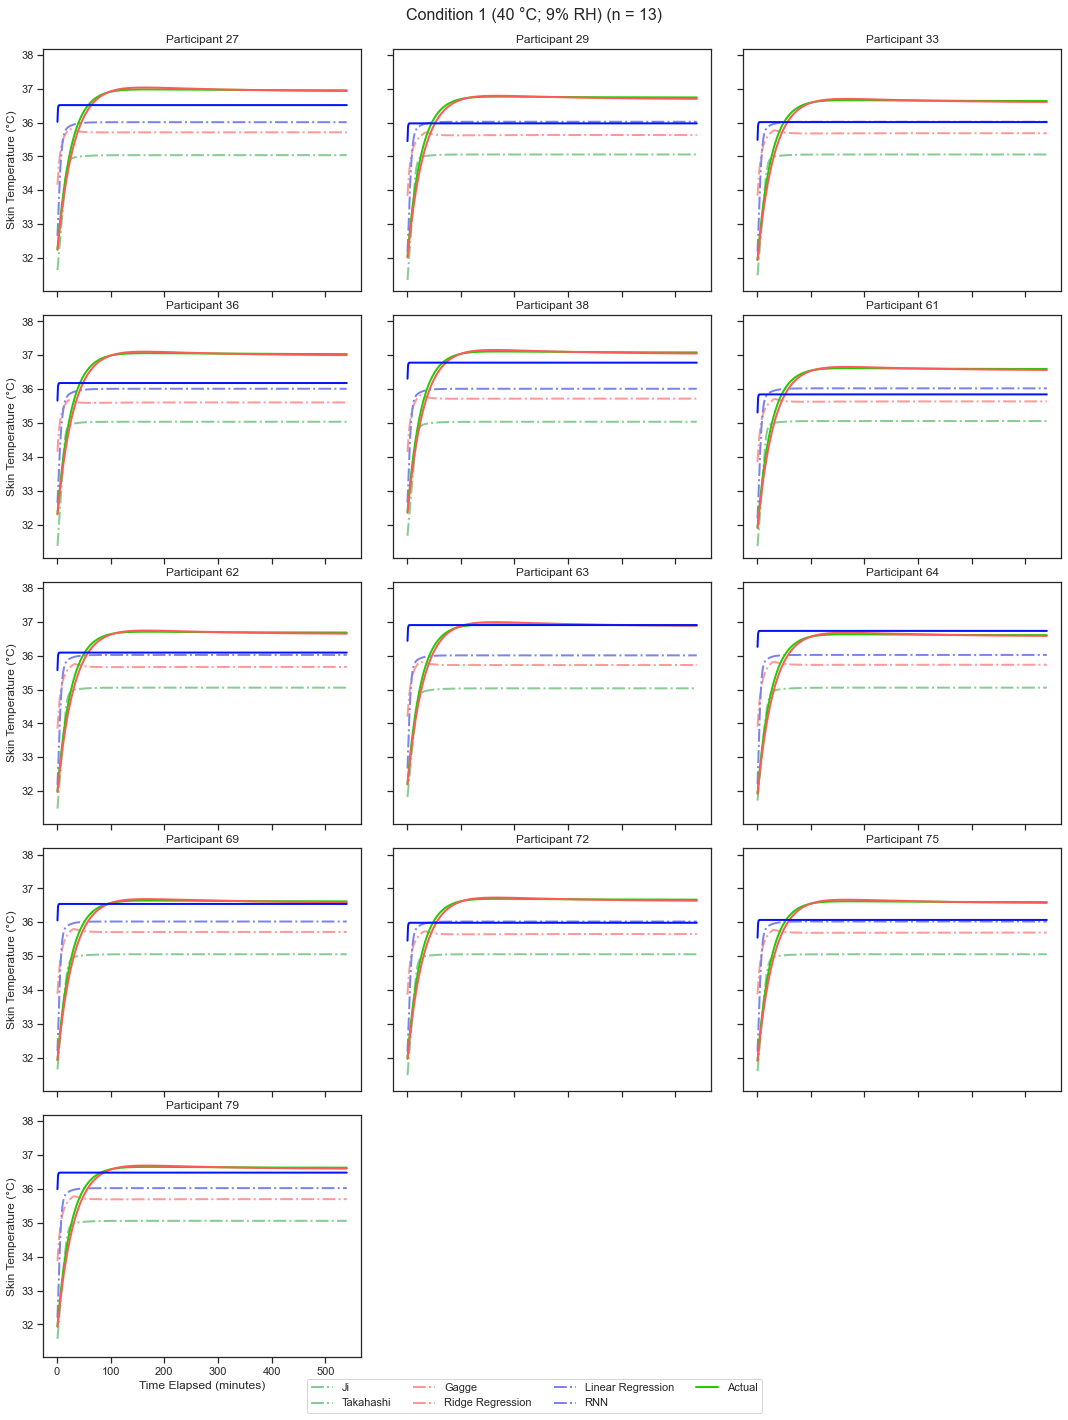

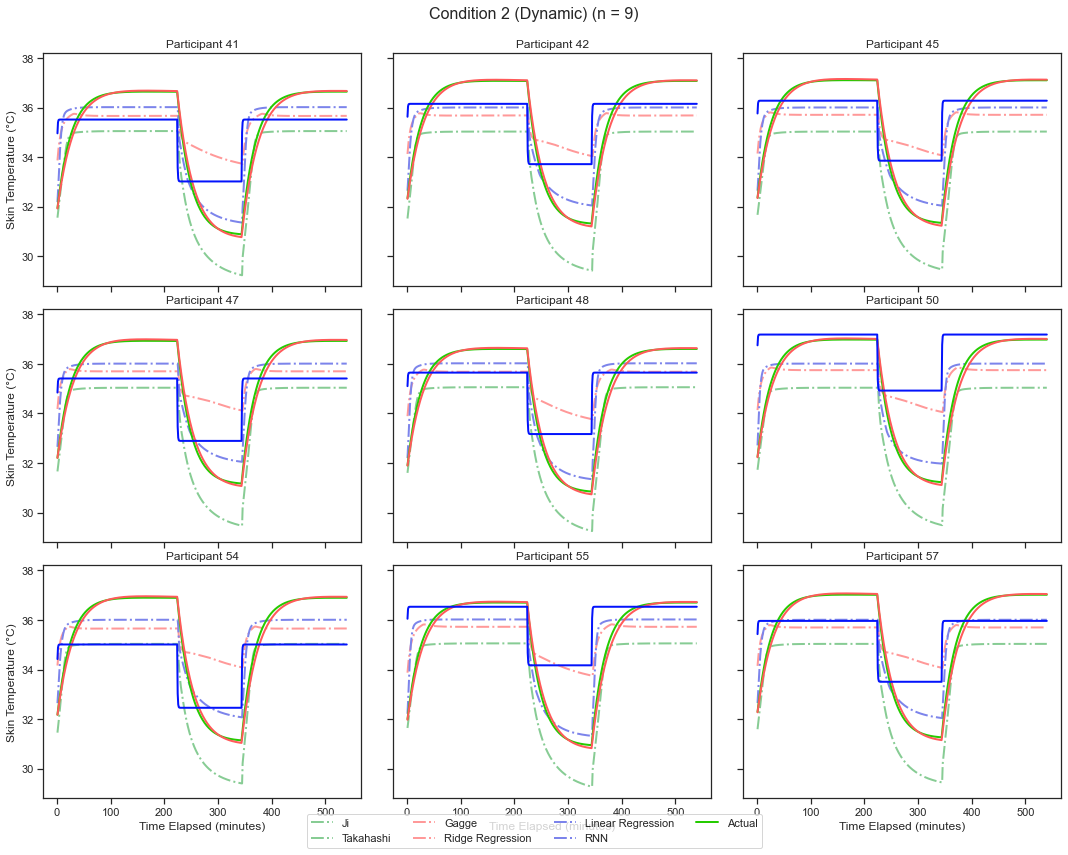

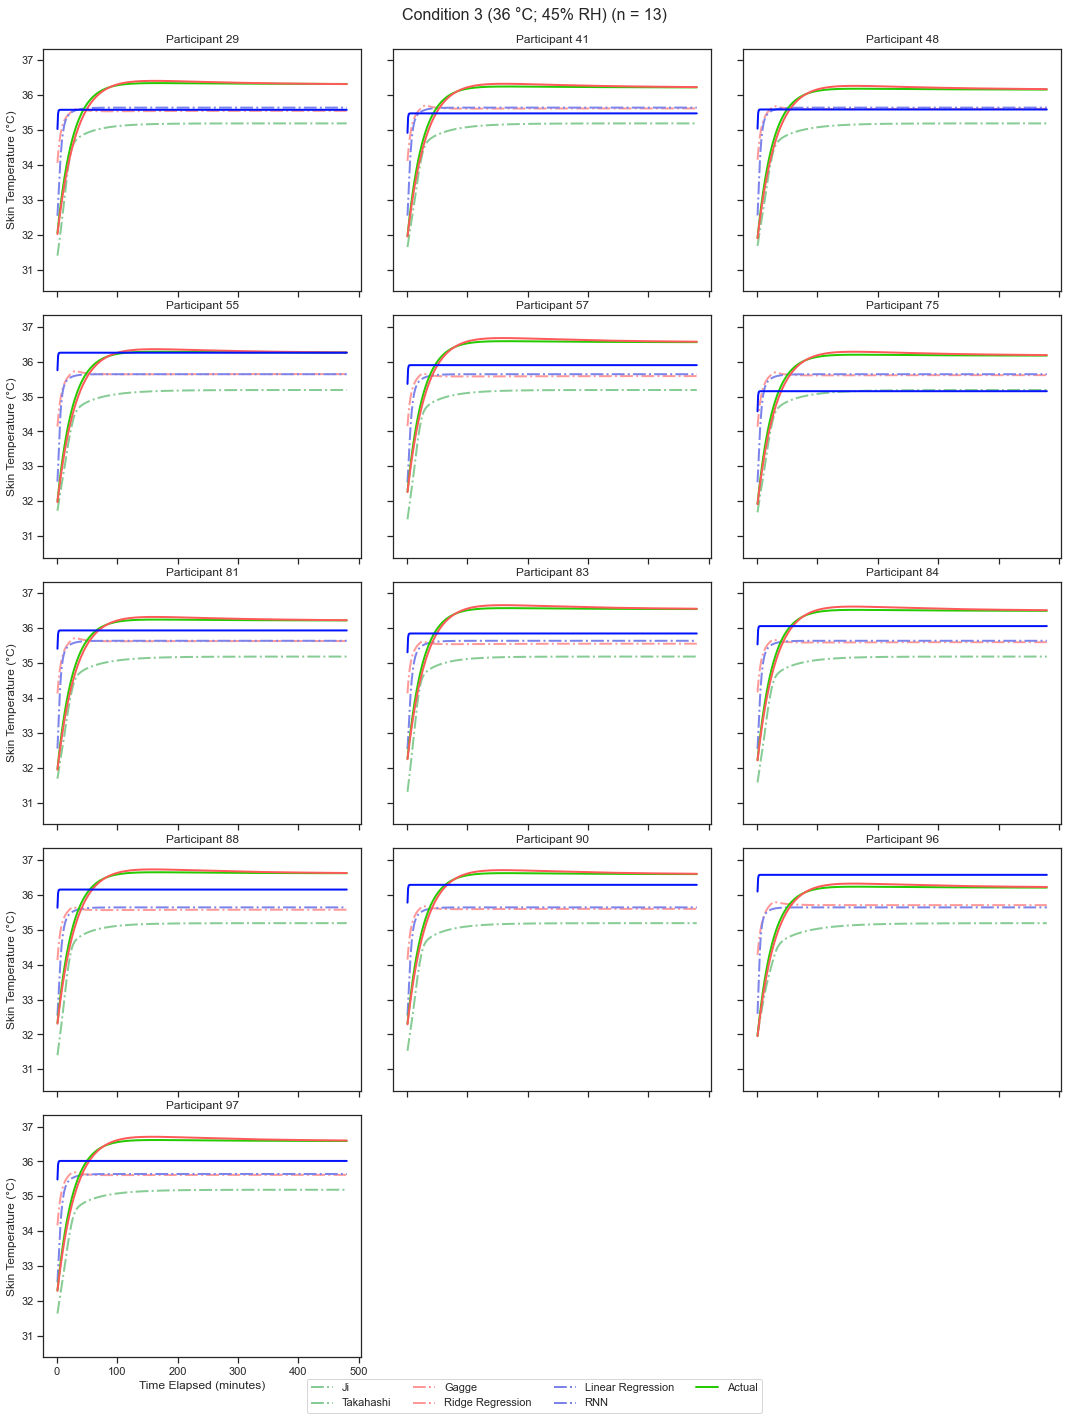

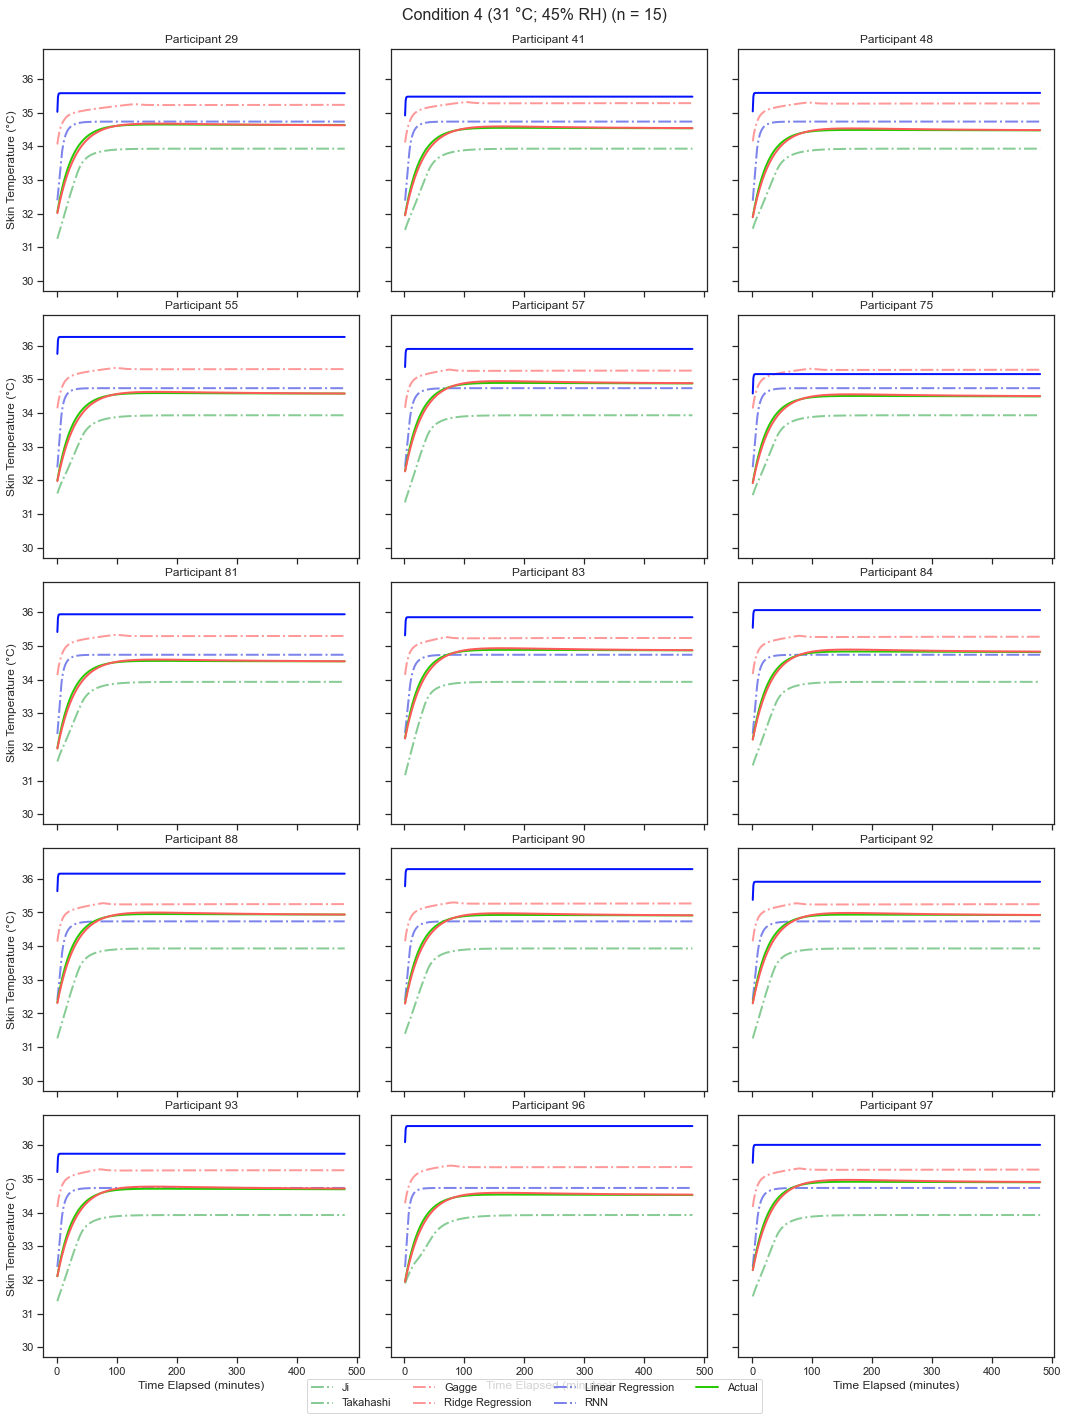

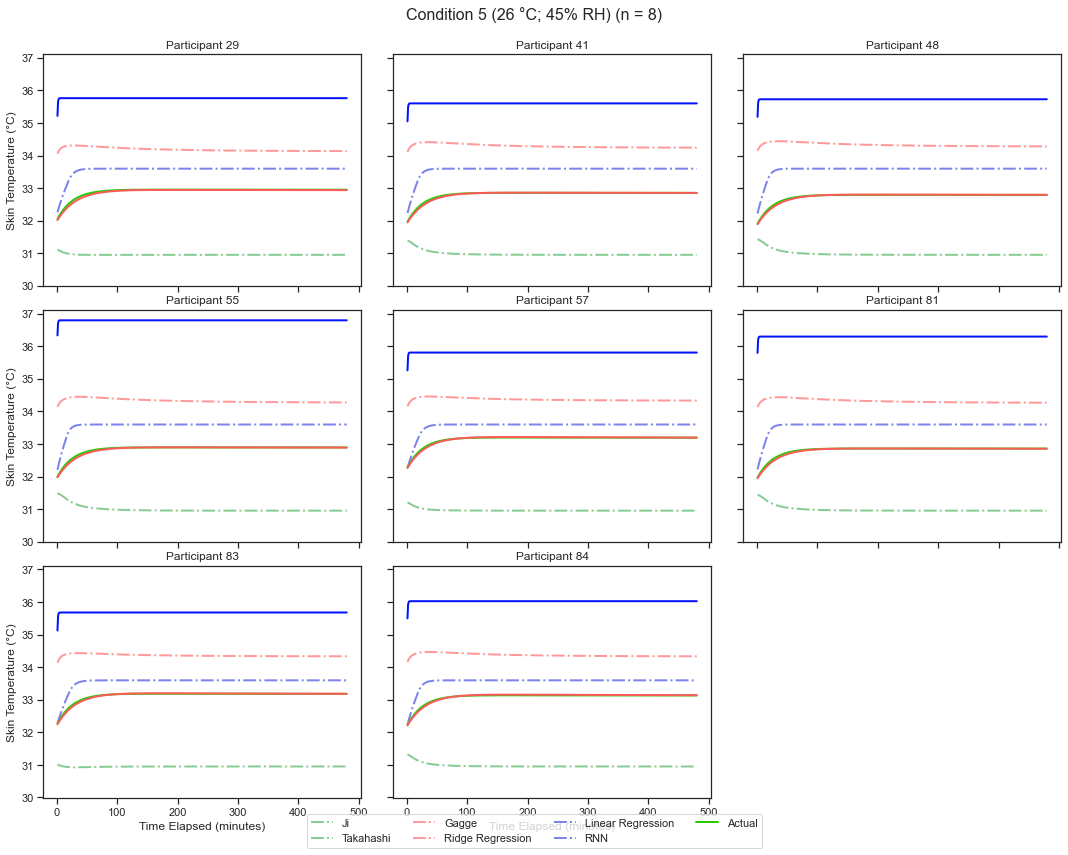

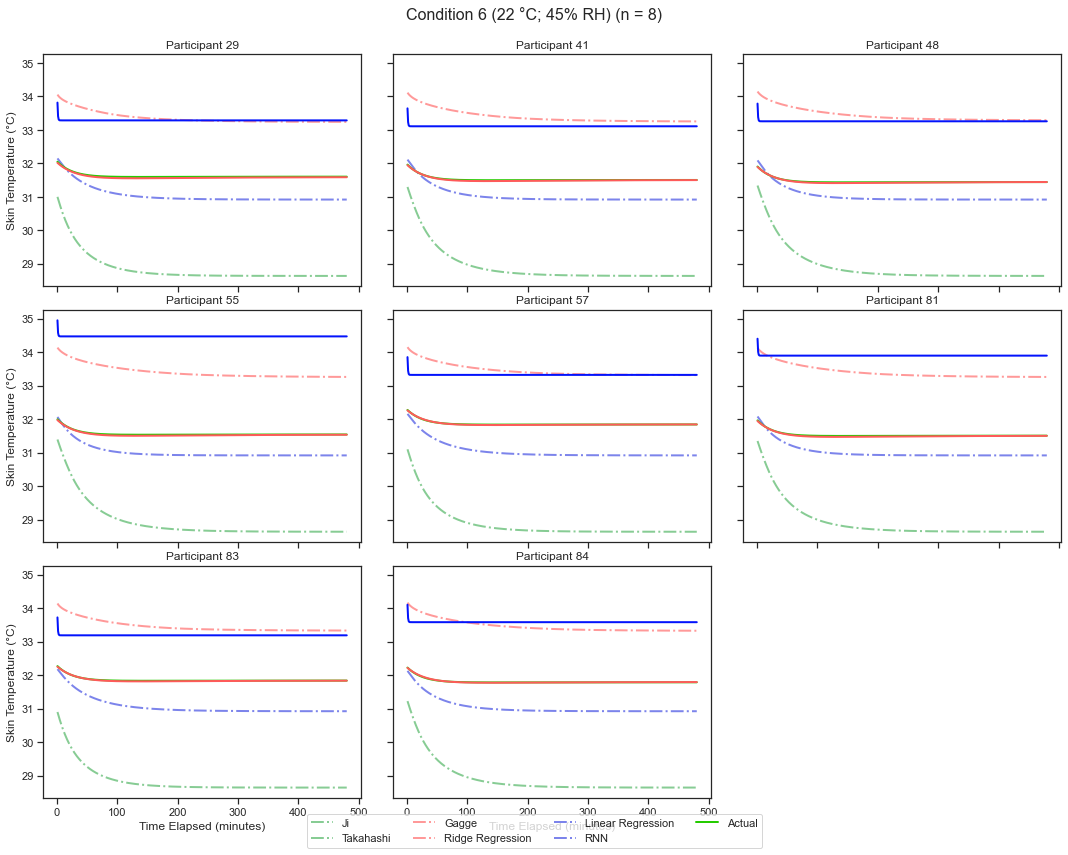

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

legend_labels = {
    'ji': 'Ji',
    'takahashi': 'Takahashi',
    'gagge': 'Gagge',
    'ml_ridge_regression': 'Ridge Regression',
    'ml_linear_regression': 'Linear Regression',
    'ml_rnn': 'RNN',
}

def plot_models_by_participant(samples, temp_type='tre'):
    temp_column = f'{temp_type}_int'
    sns.set(style="ticks")

    biophysical_models = ['ji', 'takahashi', 'gagge']
    ml_models = ['ml_ridge_regression', 'ml_linear_regression', 'ml_rnn']
    all_models = biophysical_models + ml_models

    biophysical_colors = ['#87CC94', '#FF9999', '#7c84eb']
    ml_colors = ['#25CB00', '#FF5A5A', '#0313fc']
    all_colors = biophysical_colors + ml_colors

    for idx, sample in enumerate(samples):
        study = sample.study.iloc[0]
        condition = sample.condition.iloc[0]
        sample = sample[sample.age >= 60]

        # Get unique participants
        participants = sample.id_all.unique()
        # Sort participants by ID
        participants = np.sort(participants)
        n_participants = len(participants)

        # Calculate rows based on number of participants (always 3 columns)
        n_cols = 3
        n_rows = math.ceil(n_participants / n_cols)

        # Dynamically calculate figure size
        fig_width = 5 * n_cols
        fig_height = 4 * n_rows

        fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), sharex=True, sharey=True)
        axs = axs.flatten()

        handles = []
        labels = [legend_labels[model] for model in all_models] + ["Actual"]

        # Initialize min and max values for y-axis
        y_min, y_max = float('inf'), float('-inf')

        for participant_idx, participant in enumerate(participants):
            participant_data = sample[sample.id_all == participant]
            participant_data = participant_data.sort_values('time')

            # Plotting the predicted data for all models
            for model, color in zip(all_models, all_colors):
                model_column = f'{temp_type}_predicted_{model}'
                if model_column in participant_data.columns:
                    line_style = '-.' if model in biophysical_models else '-'
                    line, = axs[participant_idx].plot(participant_data.time, participant_data[model_column],
                                                      linewidth=2, linestyle=line_style, color=color)
                    if participant_idx == 0:
                        handles.append(line)

                    # Update min and max values
                    y_min = min(y_min, participant_data[model_column].min())
                    y_max = max(y_max, participant_data[model_column].max())
                else:
                    print(f"Column {model_column} not found in {study} {condition} dataframe for participant {participant}.")

            # Plotting the actual data
            # line, = axs[participant_idx].plot(participant_data.time, participant_data[temp_column], linewidth=2, color="black")
            # if participant_idx == 0:
                handles.append(line)

            # Update min and max values for actual data
            y_min = min(y_min, participant_data[temp_column].min())
            y_max = max(y_max, participant_data[temp_column].max())

            axs[participant_idx].set_title(f'Participant {participant}')

            if participant_idx % n_cols != 0:
                axs[participant_idx].set_ylabel("")
            else:
                axs[participant_idx].set_ylabel(f"{'Rectal' if temp_column == 'tre_int' else 'Skin'} Temperature (°C)")

            if participant_idx < (n_rows - 1) * n_cols:
                axs[participant_idx].set_xlabel("")
            else:
                axs[participant_idx].set_xlabel("Time Elapsed (minutes)")

        # Set y-axis limits for all subplots
        y_range = y_max - y_min
        y_padding = 0.05 * y_range  # Add 5% padding
        for ax in axs:
            ax.set_ylim(y_min - y_padding, y_max + y_padding)

        # Remove unused subplots
        for idx_unused in range(n_participants, n_rows * n_cols):
            fig.delaxes(axs[idx_unused])

        # Adjust subplot layout
        plt.tight_layout()

        # Add legend
        legend = fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=4)

        # Add overall title for the condition
        if idx == 1:  # For the dynamic condition
            title = f'Condition {idx+1} (Dynamic) (n = {n_participants})'
        else:
            title = f'Condition {idx+1} ({sample.ta_set.iloc[0]} °C; {sample.rh_set.iloc[0]}% RH) (n = {n_participants})'

        fig.suptitle(title, fontsize=16, y=0.98)

        # Adjust layout to make room for title and legend
        plt.tight_layout(rect=[0, 0.01, 1, 0.99])

        # Adjust the padding between subplots
        plt.subplots_adjust(hspace=0.1, wspace=0.1)

        plt.savefig(f"figures/{temp_type}_line_chart_condition_{idx+1}_all_models.pdf", format='pdf', dpi=300, bbox_inches='tight')
        plt.show()

# Plot rectal temperature for all models
plot_models_by_participant(samples, temp_type='tre')

# Plot skin temperature for all models
plot_models_by_participant(samples, temp_type='mtsk')